# Transfer Learning Part 2: Fine-tuning 

## IMporting helper functions

Rewriting certain functions to monitor and evaluate our model can be tedious, so we can make our own script for some mundane activities

### Downloading hellper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
import tensorflow as tf

device = tf.config.list_physical_devices('GPU')

In [2]:
# IMporting from helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get Some data

# Get 10% of our data and unzip it

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [4]:
# Create training and test directory paths
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.


Found 2500 files belonging to 10 classes.


2024-02-15 02:51:03.559068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-15 02:51:03.559091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-15 02:51:03.559097: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-15 02:51:03.559147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-15 02:51:03.559354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an axample of batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.44974487e+02 1.39260208e+02 1.33260208e+02]
   [1.38943878e+02 1.33229599e+02 1.27229591e+02]
   [1.38622452e+02 1.29632645e+02 1.27127548e+02]
   ...
   [8.48622589e+01 8.30765228e+01 8.80765228e+01]
   [8.70713882e+01 8.50713882e+01 9.00713882e+01]
   [8.40561371e+01 8.01275635e+01 8.64132767e+01]]

  [[1.26076530e+02 1.14790817e+02 1.10862244e+02]
   [1.38545914e+02 1.27331635e+02 1.23403061e+02]
   [1.28806122e+02 1.18780609e+02 1.16765305e+02]
   ...
   [8.40152817e+01 8.25560608e+01 8.67448959e+01]
   [8.14387360e+01 7.95101700e+01 8.45101700e+01]
   [8.06480331e+01 7.87194672e+01 8.37194672e+01]]

  [[1.21938774e+02 1.06938774e+02 1.03938774e+02]
   [1.28290817e+02 1.14290817e+02 1.11290817e+02]
   [1.31647964e+02 1.21908165e+02 1.19693878e+02]
   ...
   [8.15968781e+01 8.15968781e+01 8.35968781e+01]
   [7.77704086e+01 7.75561218e+01 8.01989746e+01]
   [8.21430283e+01 8.19287415e+01 8.45716019e+01]]

  ...

  [[5.12806091e+01 4.72806091e+01 4.42806091e+01]
   [5

## Model 0: Building a transfer learning model using Keras Functionsal API

The sequential API is straight-forwar, it runs our layers in sequential order.

But the functiosn API gives us more flexibility with our models

In [11]:
# 1. Create base model, with tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")

# 4. If using a model like ResNEt50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average poo the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)


# 8. Combing the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# 10. Fit the model and save its hsitory
history_0 = model_0.fit(train_data,
                        epochs= 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= len(test_data),
                        callbacks= [create_tensorboard_callback(
                            dir_name= "tensorflow_hub", experiment_name= 'model_0')]) 

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/model_0/20240215-025105
Epoch 1/5


2024-02-15 02:51:07.333785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-15 02:51:07.463626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 11s 352ms/step - loss: 1.9709 - accuracy: 0.3613 - val_loss: 1.4353 - val_accuracy: 0.6904
Epoch 2/5
24/24 [==============================] - 5s 224ms/step - loss: 1.2421 - accuracy: 0.7373 - val_loss: 0.9645 - val_accuracy: 0.7996
Epoch 3/5
24/24 [==============================] - 5s 218ms/step - loss: 0.9241 - accuracy: 0.7933 - val_loss: 0.7639 - val_accuracy: 0.8296
Epoch 4/5
24/24 [==============================] - 5s 221ms/step - loss: 0.7496 - accuracy: 0.8293 - val_loss: 0.6590 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 5s 220ms/step - loss: 0.6639 - accuracy: 0.8547 - val_loss: 0.5959 - val_accuracy: 0.8576


In [12]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 4s 52ms/step - loss: 0.5959 - accuracy: 0.8576


[0.5958852767944336, 0.8575999736785889]

In [13]:
# Check the layers in our base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

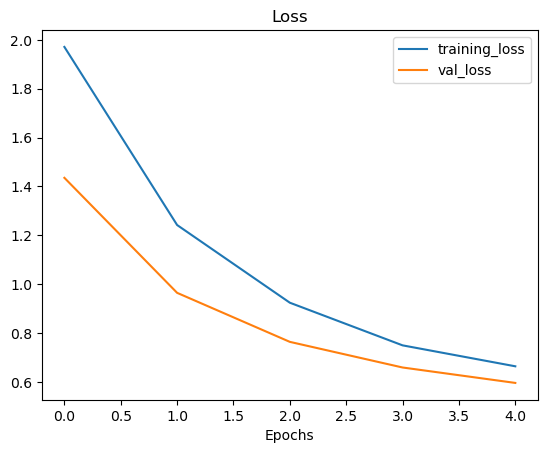

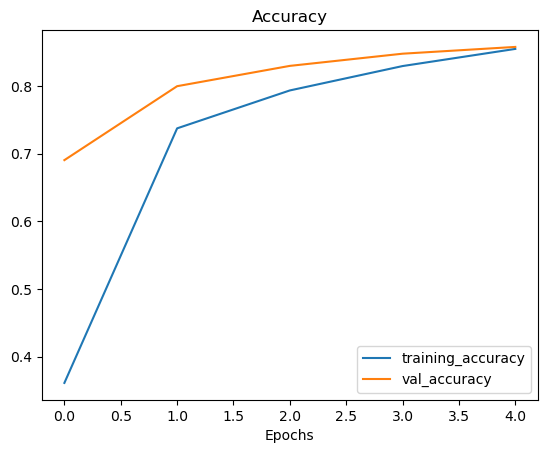

In [16]:
plot_loss_curves(history_0)

## Getting feature vector form trained model

Let's demonstrate GlobalAveragePooling2D layer

We have a tensor after our modle goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.

In [17]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor} \n")

# Passing the random tensor trhough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

#Check the shape of the different tensord
print(f"Shape of input tensord: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensord: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]] 

2D global average pooled random tensor: 
 [[-0.09368647 -0.45840445 -0.28855982]] 

Shape of input tensord: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensord: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

> **Practice**: Try to do the same withthe above two cells but this time use `GlobalMaxPool2D` ... and see what happens

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunmch of experiments to find out:

1. `model_1` use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation


> **Note**: throughout all the experiments the same test dataset will be used to evaluate our model... thsi ensures consistency across evaluation metrics

## Getting and preprocessing our data for model_1

# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

In [19]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [20]:
# Creating training and test dir
TRAIN_DIR_1 = "10_food_classes_1_percent/train/"
TEST_DIR_1 = "10_food_classes_1_percent/test/"

In [21]:
# Setup data loaders

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into out model, we can us the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this in the documentations of data augmentatioon inside the model

* Preprocessing of the images happens in GPU
* The preprocessing layers are also saved when the model is being saved to use as an idependent application

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # Keep for models like ResNet50 but EfficientNet already has the layer in built
], name= "data_augmentation")

(-0.5, 511.5, 511.5, -0.5)

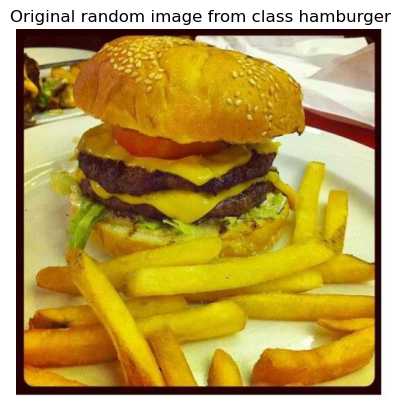

In [24]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

### Visualise or data augmentation layer

2024-02-15 02:51:43.400797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


(-0.5, 498.5, 536.5, -0.5)

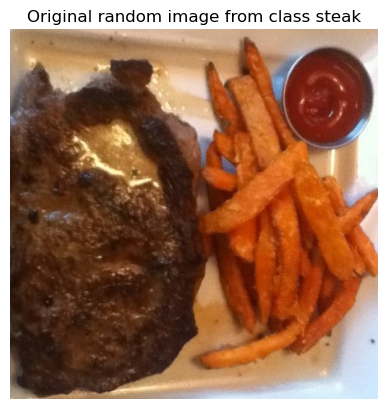

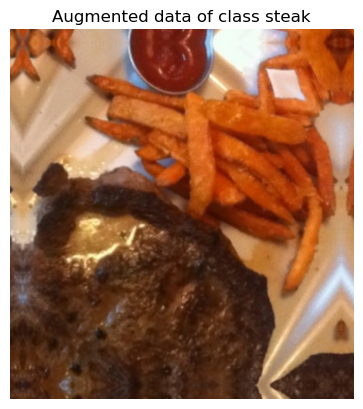

In [25]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis= 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented data of class {target_class}")
plt.axis(False)

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup the input shape and base model, freezing the base model layers

input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape= input_shape, name= 'input_layer')

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training= False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [27]:
history_1_percent = model_1.fit(train_data_1, 
            epochs= 5,
            steps_per_epoch= len(train_data_1),
            validation_data= test_data_1,
            validation_steps= len(test_data_1),
            callbacks= [create_tensorboard_callback("tensorflow_hub", "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20240215-025145
Epoch 1/5


2024-02-15 02:51:47.495666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 5s - loss: 2.3763 - accuracy: 0.1562

2024-02-15 02:51:48.467213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 2.3933 - accuracy: 0.1094

2024-02-15 02:51:49.017551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 13s 5s/step - loss: 2.3726 - accuracy: 0.1000 - val_loss: 2.2287 - val_accuracy: 0.1644
Epoch 2/5


2024-02-15 02:51:58.126596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 2s - loss: 2.1759 - accuracy: 0.2188

2024-02-15 02:51:59.139687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 2.1214 - accuracy: 0.2656

2024-02-15 02:51:59.796379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 4s/step - loss: 2.0879 - accuracy: 0.3143 - val_loss: 2.0995 - val_accuracy: 0.2596
Epoch 3/5


2024-02-15 02:52:06.231587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 1.9115 - accuracy: 0.5000

2024-02-15 02:52:06.913587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 1.8900 - accuracy: 0.4844

2024-02-15 02:52:07.466644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 4s/step - loss: 1.9195 - accuracy: 0.4429 - val_loss: 1.9853 - val_accuracy: 0.3592
Epoch 4/5


2024-02-15 02:52:13.920557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 1.7557 - accuracy: 0.5000

2024-02-15 02:52:14.610362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 1.7492 - accuracy: 0.4844

2024-02-15 02:52:15.283318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 7s 3s/step - loss: 1.7416 - accuracy: 0.5000 - val_loss: 1.8835 - val_accuracy: 0.4460
Epoch 5/5


2024-02-15 02:52:21.318116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 0s - loss: 1.5551 - accuracy: 0.6250

2024-02-15 02:52:21.816342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 1.5984 - accuracy: 0.5938

2024-02-15 02:52:22.724552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 4s/step - loss: 1.5970 - accuracy: 0.6143 - val_loss: 1.7918 - val_accuracy: 0.4980


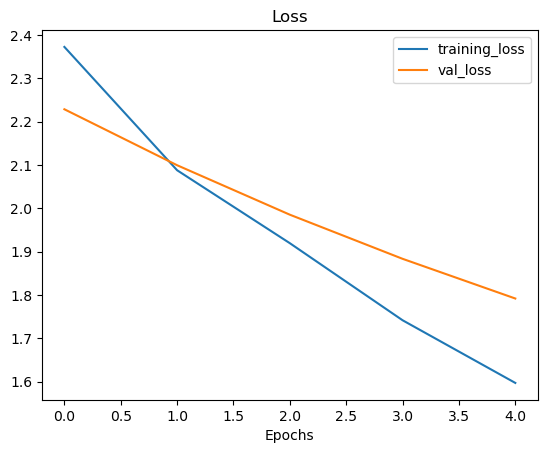

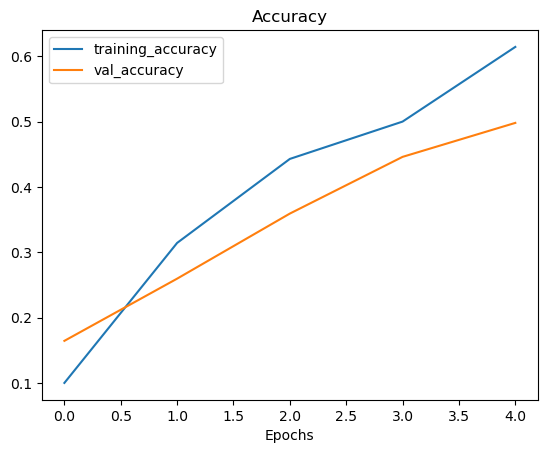

In [28]:
plot_loss_curves(history_1_percent)

In [29]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [30]:
# Evaluate
model_1.evaluate(test_data_1)

79/79 [==============================] - 6s 72ms/step - loss: 1.7918 - accuracy: 0.4980


[1.7918310165405273, 0.49799999594688416]

## Model 2: feature extraction transfer learning model with 10% data and data augmentation

In [31]:
# Get 10 % of our data
train_dir_10 = "10_food_classes_10_percent/train"
test_dir_10 = "10_food_classes_10_percent/test"

In [32]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [33]:
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

Found 750 files belonging to 10 classes.


Found 2500 files belonging to 10 classes.


In [34]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [35]:
# Create model 2 with data augmentation built in
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name= 'data_augmentation')

# Setup the input shape
input_shape = IMG_SIZE + (3, )

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape= input_shape, name= 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_poolonmg_2D')(x)
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [36]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_poolonmg_2D  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback immediately saves our model so that we can start where left. 

In [37]:
# Set checkpoint path
checkpoint_path = 'model_checkpoints/weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, save_weights_only= True, save_best_only= False, save_freq= 'epoch', verbose= 1)

In [38]:
history_10_percent = model_2.fit(train_data_10,
            epochs= 5,
            steps_per_epoch= len(train_data_10),
            validation_data= test_data_10,
            validation_steps= len(test_data_10),
            callbacks= [create_tensorboard_callback('tensorflow_hub', "10_percent_data_aug"),
                        checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20240215-025236
Epoch 1/5


2024-02-15 02:52:38.716207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 1:40 - loss: 2.2509 - accuracy: 0.1875

2024-02-15 02:52:40.969132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 34s - loss: 2.3330 - accuracy: 0.1094 

2024-02-15 02:52:42.540605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 23s - loss: 2.3294 - accuracy: 0.1146

2024-02-15 02:52:43.176767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 22s - loss: 2.3263 - accuracy: 0.1016

2024-02-15 02:52:44.317023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 20s - loss: 2.2909 - accuracy: 0.1063

2024-02-15 02:52:45.309186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 17s - loss: 2.2643 - accuracy: 0.1302

2024-02-15 02:52:45.737134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 14s - loss: 2.2404 - accuracy: 0.1518

2024-02-15 02:52:46.184853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 14s - loss: 2.2297 - accuracy: 0.1641

2024-02-15 02:52:47.353051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 12s - loss: 2.2123 - accuracy: 0.1806

2024-02-15 02:52:47.867901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 12s - loss: 2.2024 - accuracy: 0.1813

2024-02-15 02:52:48.765655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 10s - loss: 2.1784 - accuracy: 0.2017

2024-02-15 02:52:49.021736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 9s - loss: 2.1630 - accuracy: 0.2161 

2024-02-15 02:52:49.994708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 8s - loss: 2.1445 - accuracy: 0.2284

2024-02-15 02:52:50.653158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 8s - loss: 2.1170 - accuracy: 0.2545

2024-02-15 02:52:51.416350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 2.0877 - accuracy: 0.2750

2024-02-15 02:52:52.506335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 2.0737 - accuracy: 0.2910

2024-02-15 02:52:54.110568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 2.0534 - accuracy: 0.3033

2024-02-15 02:52:55.083144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 2.0373 - accuracy: 0.3108

2024-02-15 02:52:55.991762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 2.0218 - accuracy: 0.3224

2024-02-15 02:52:57.493309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 2.0009 - accuracy: 0.3391

2024-02-15 02:52:58.099549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 1.9943 - accuracy: 0.3452

2024-02-15 02:52:59.119715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 1.9691 - accuracy: 0.3622

2024-02-15 02:53:00.395145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 1.9552 - accuracy: 0.3764

2024-02-15 02:53:01.022311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.3720
Epoch 1: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 38s 1s/step - loss: 1.9564 - accuracy: 0.3720 - val_loss: 1.4017 - val_accuracy: 0.6804
Epoch 2/5


2024-02-15 02:53:14.789059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 22s - loss: 1.5997 - accuracy: 0.6250

2024-02-15 02:53:15.750250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 20s - loss: 1.5341 - accuracy: 0.6250

2024-02-15 02:53:16.680745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 16s - loss: 1.4645 - accuracy: 0.6667

2024-02-15 02:53:17.312034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 13s - loss: 1.3991 - accuracy: 0.6875

2024-02-15 02:53:17.837834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 14s - loss: 1.3893 - accuracy: 0.7063

2024-02-15 02:53:18.761639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 12s - loss: 1.4014 - accuracy: 0.7031

2024-02-15 02:53:19.299368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 13s - loss: 1.3944 - accuracy: 0.7009

2024-02-15 02:53:20.604233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 12s - loss: 1.3768 - accuracy: 0.7188

2024-02-15 02:53:21.345162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 11s - loss: 1.3866 - accuracy: 0.7292

2024-02-15 02:53:22.045206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 11s - loss: 1.3721 - accuracy: 0.7281

2024-02-15 02:53:23.042896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 10s - loss: 1.3642 - accuracy: 0.7216

2024-02-15 02:53:23.879105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 9s - loss: 1.3656 - accuracy: 0.7135 

2024-02-15 02:53:24.744250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 9s - loss: 1.3479 - accuracy: 0.7188

2024-02-15 02:53:26.777217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 9s - loss: 1.3407 - accuracy: 0.7165

2024-02-15 02:53:27.615450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 8s - loss: 1.3444 - accuracy: 0.7083

2024-02-15 02:53:29.080934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 1.3390 - accuracy: 0.7090

2024-02-15 02:53:29.572468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 1.3309 - accuracy: 0.7114

2024-02-15 02:53:30.313584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 1.3247 - accuracy: 0.7135

2024-02-15 02:53:30.976924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 1.3243 - accuracy: 0.7089

2024-02-15 02:53:31.898124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 1.3174 - accuracy: 0.7094

2024-02-15 02:53:32.676396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 1.3086 - accuracy: 0.7128

2024-02-15 02:53:33.611508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 1.3055 - accuracy: 0.7074

2024-02-15 02:53:33.962445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 1.2909 - accuracy: 0.7120

2024-02-15 02:53:35.611159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.2886 - accuracy: 0.7133
Epoch 2: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 1.2886 - accuracy: 0.7133 - val_loss: 0.9747 - val_accuracy: 0.7844
Epoch 3/5


2024-02-15 02:53:43.194021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 16s - loss: 1.0782 - accuracy: 0.7500

2024-02-15 02:53:43.920251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 18s - loss: 1.0013 - accuracy: 0.7812

2024-02-15 02:53:44.747212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 15s - loss: 1.0394 - accuracy: 0.7396

2024-02-15 02:53:45.408693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 15s - loss: 1.0239 - accuracy: 0.7500

2024-02-15 02:53:46.204950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 13s - loss: 1.0422 - accuracy: 0.7437

2024-02-15 02:53:46.745277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 13s - loss: 1.0669 - accuracy: 0.7292

2024-02-15 02:53:47.544531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 14s - loss: 1.0586 - accuracy: 0.7321

2024-02-15 02:53:48.965943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 13s - loss: 1.0638 - accuracy: 0.7188

2024-02-15 02:53:49.988246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 12s - loss: 1.0613 - accuracy: 0.7222

2024-02-15 02:53:50.801704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 11s - loss: 1.0719 - accuracy: 0.7188

2024-02-15 02:53:51.369055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 10s - loss: 1.0716 - accuracy: 0.7216

2024-02-15 02:53:51.808481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 9s - loss: 1.0690 - accuracy: 0.7266 

2024-02-15 02:53:52.694593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 8s - loss: 1.0669 - accuracy: 0.7260

2024-02-15 02:53:53.238567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 8s - loss: 1.0644 - accuracy: 0.7188

2024-02-15 02:53:54.388574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 1.0618 - accuracy: 0.7167

2024-02-15 02:53:55.250394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 6s - loss: 1.0499 - accuracy: 0.7246

2024-02-15 02:53:56.129992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 5s - loss: 1.0358 - accuracy: 0.7316

2024-02-15 02:53:57.336724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 4s - loss: 1.0175 - accuracy: 0.7413

2024-02-15 02:53:57.832305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 1.0124 - accuracy: 0.7451

2024-02-15 02:53:58.877396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 1.0131 - accuracy: 0.7469

2024-02-15 02:53:59.770262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 1.0134 - accuracy: 0.7485

2024-02-15 02:54:00.607838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 1.0094 - accuracy: 0.7500

2024-02-15 02:54:01.661121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 1.0049 - accuracy: 0.7527

2024-02-15 02:54:02.997780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.7520
Epoch 3: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 1.0066 - accuracy: 0.7520 - val_loss: 0.7853 - val_accuracy: 0.8196
Epoch 4/5


2024-02-15 02:54:10.842364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 16s - loss: 0.9227 - accuracy: 0.8125

2024-02-15 02:54:11.542880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 16s - loss: 0.9752 - accuracy: 0.7812

2024-02-15 02:54:12.268773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 13s - loss: 0.8974 - accuracy: 0.7812

2024-02-15 02:54:12.795254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 13s - loss: 0.9202 - accuracy: 0.7578

2024-02-15 02:54:13.511124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 13s - loss: 0.9181 - accuracy: 0.7625

2024-02-15 02:54:14.323648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 13s - loss: 0.9027 - accuracy: 0.7500

2024-02-15 02:54:15.382104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 14s - loss: 0.8674 - accuracy: 0.7679

2024-02-15 02:54:16.698712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 13s - loss: 0.8980 - accuracy: 0.7539

2024-02-15 02:54:17.662651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 14s - loss: 0.8806 - accuracy: 0.7674

2024-02-15 02:54:19.270941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 13s - loss: 0.9015 - accuracy: 0.7719

2024-02-15 02:54:20.515985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 12s - loss: 0.9021 - accuracy: 0.7784

2024-02-15 02:54:21.304607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 11s - loss: 0.8883 - accuracy: 0.7865

2024-02-15 02:54:22.247592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 10s - loss: 0.8763 - accuracy: 0.7957

2024-02-15 02:54:22.834977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 9s - loss: 0.8651 - accuracy: 0.7991 

2024-02-15 02:54:23.386841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 0.8520 - accuracy: 0.8083

2024-02-15 02:54:23.944079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 0.8481 - accuracy: 0.8086

2024-02-15 02:54:24.713012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 0.8622 - accuracy: 0.7996

2024-02-15 02:54:25.910546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 0.8597 - accuracy: 0.8003

2024-02-15 02:54:26.568896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 0.8462 - accuracy: 0.8059

2024-02-15 02:54:27.116740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 0.8447 - accuracy: 0.8047

2024-02-15 02:54:28.259521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 0.8443 - accuracy: 0.8036

2024-02-15 02:54:29.293103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 0.8482 - accuracy: 0.8026

2024-02-15 02:54:30.397065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 0.8465 - accuracy: 0.8030

2024-02-15 02:54:31.057540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.8427 - accuracy: 0.8053
Epoch 4: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 0.8427 - accuracy: 0.8053 - val_loss: 0.6854 - val_accuracy: 0.8328
Epoch 5/5


2024-02-15 02:54:39.277837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 18s - loss: 0.8298 - accuracy: 0.8750

2024-02-15 02:54:40.098746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 13s - loss: 0.8364 - accuracy: 0.8125

2024-02-15 02:54:40.710795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 14s - loss: 0.7582 - accuracy: 0.8333

2024-02-15 02:54:41.960182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 16s - loss: 0.8159 - accuracy: 0.8047

2024-02-15 02:54:42.574325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 18s - loss: 0.8139 - accuracy: 0.8000

2024-02-15 02:54:44.079939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 18s - loss: 0.7908 - accuracy: 0.8073

2024-02-15 02:54:45.138214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 15s - loss: 0.7965 - accuracy: 0.8080

2024-02-15 02:54:45.697141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 15s - loss: 0.7818 - accuracy: 0.8125

2024-02-15 02:54:46.722364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 14s - loss: 0.7569 - accuracy: 0.8194

2024-02-15 02:54:47.616518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 13s - loss: 0.7623 - accuracy: 0.8219

2024-02-15 02:54:49.083658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 13s - loss: 0.7673 - accuracy: 0.8182

2024-02-15 02:54:50.175811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 12s - loss: 0.7724 - accuracy: 0.8203

2024-02-15 02:54:51.340236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 10s - loss: 0.7641 - accuracy: 0.8221

2024-02-15 02:54:51.793990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 9s - loss: 0.7771 - accuracy: 0.8147 

2024-02-15 02:54:52.817345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 8s - loss: 0.7744 - accuracy: 0.8125

2024-02-15 02:54:53.387147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 0.7770 - accuracy: 0.8125

2024-02-15 02:54:54.444323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 0.7705 - accuracy: 0.8143

2024-02-15 02:54:56.005939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 6s - loss: 0.7673 - accuracy: 0.8125

2024-02-15 02:54:57.497809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 5s - loss: 0.7611 - accuracy: 0.8125

2024-02-15 02:54:58.527899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 4s - loss: 0.7700 - accuracy: 0.8094

2024-02-15 02:54:59.249520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 0.7592 - accuracy: 0.8095

2024-02-15 02:54:59.814506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 0.7560 - accuracy: 0.8125

2024-02-15 02:55:00.769798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 0.7435 - accuracy: 0.8166

2024-02-15 02:55:01.670689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.8187
Epoch 5: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 32s 1s/step - loss: 0.7380 - accuracy: 0.8187 - val_loss: 0.6213 - val_accuracy: 0.8456


In [39]:
model_0.evaluate(test_data)

79/79 [==============================] - 15s 136ms/step - loss: 0.5959 - accuracy: 0.8576


[0.5958852767944336, 0.8575999736785889]

In [40]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 9s 111ms/step - loss: 0.6213 - accuracy: 0.8456


[0.621337890625, 0.8456000089645386]

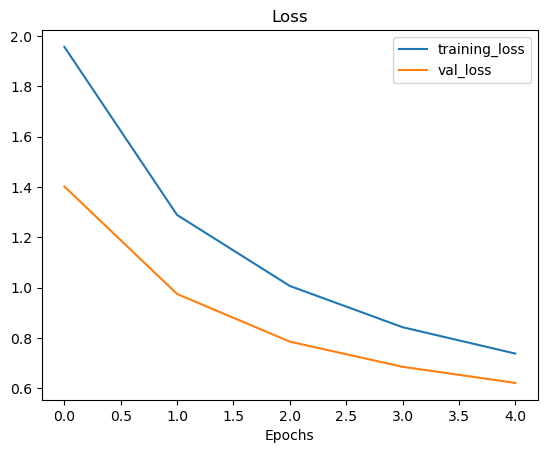

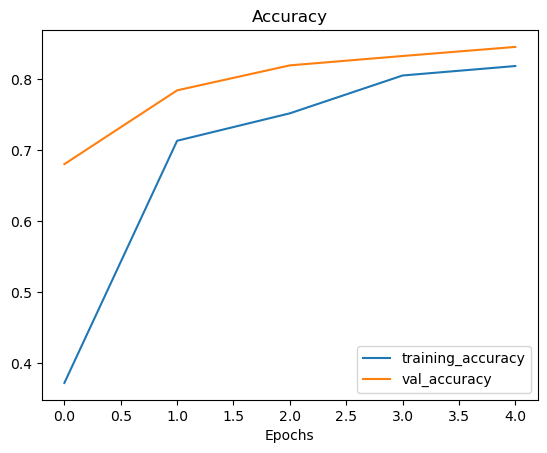

In [41]:
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint

In [42]:
# Load in saved models weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [43]:
# Evaluate model_2 with loaded weights
model_2.evaluate(test_data_10)

79/79 [==============================] - 9s 109ms/step - loss: 0.6213 - accuracy: 0.8456


[0.6213377118110657, 0.8456000089645386]

In [44]:
# Check to see if loaded model results are very close to our previous non-loaded model results

# import numpy as np
# np.isclose()

## Model 3: Fine-tuning an existing model on 10% of the data

> **Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom dataset

In [45]:
# Layers in loaded model
model_2.layers

In [46]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x3586c4160> True
<keras.src.engine.sequential.Sequential object at 0x2f2701ab0> True
<keras.src.engine.functional.Functional object at 0x3ea4e6f80> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x2d7ddaa10> True
<keras.src.layers.core.dense.Dense object at 0x3ea496170> True


In [47]:
# LAyers in out base model and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [48]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [49]:
# To begin fine tuning let;s start by setting the last 10 layers of our bas_model.tranable = True

base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we recompile our models every time we make a change)
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001), # when fine tuning you typically want to lower your learning rate by 10x
                metrics= ['accuracy'])

> **Note**: When using fine-tuning, it is a best practice to lower your learning rate. A good thumb rule is to lower it by 10x

A good resource for information on this is the [ULMFit paper](https://arxiv.org/abs/1801.06146)

In [50]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [51]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are available
len(model_2.trainable_variables)

12

In [52]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent = model_2.fit(train_data_10,
                                      epochs= fine_tune_epochs,
                                      steps_per_epoch= len(train_data_10),
                                      validation_data= test_data_10,
                                      validation_steps= int(0.25 * len(test_data_10)),
                                      initial_epoch= history_10_percent.epoch[-1], # start training from prevous last epoch,
                                      callbacks= [create_tensorboard_callback('tensorflow_hub', '10_percent_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tune/20240215-025544
Epoch 5/10


2024-02-15 02:55:46.970950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 2:08 - loss: 0.4834 - accuracy: 0.9375

2024-02-15 02:55:50.390319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 47s - loss: 0.6783 - accuracy: 0.8281 

2024-02-15 02:55:52.543534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 43s - loss: 0.7294 - accuracy: 0.7708

2024-02-15 02:55:54.525002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 40s - loss: 0.7509 - accuracy: 0.7656

2024-02-15 02:55:56.431258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 36s - loss: 0.7199 - accuracy: 0.7812

2024-02-15 02:55:58.029387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 33s - loss: 0.6766 - accuracy: 0.7917

2024-02-15 02:55:59.600472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 31s - loss: 0.6897 - accuracy: 0.7946

2024-02-15 02:56:01.551503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 31s - loss: 0.7005 - accuracy: 0.7891

2024-02-15 02:56:04.251840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 30s - loss: 0.6984 - accuracy: 0.7917

2024-02-15 02:56:06.621284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 27s - loss: 0.6986 - accuracy: 0.7906

2024-02-15 02:56:07.826392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 24s - loss: 0.6843 - accuracy: 0.7983

2024-02-15 02:56:09.284021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 23s - loss: 0.6695 - accuracy: 0.7969

2024-02-15 02:56:11.470092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 20s - loss: 0.6584 - accuracy: 0.8029

2024-02-15 02:56:13.124063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 0.6597 - accuracy: 0.8036

2024-02-15 02:56:14.996898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 16s - loss: 0.6544 - accuracy: 0.8062

2024-02-15 02:56:15.491042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 14s - loss: 0.6450 - accuracy: 0.8125

2024-02-15 02:56:16.697840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 11s - loss: 0.6438 - accuracy: 0.8107

2024-02-15 02:56:17.816425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 0.6434 - accuracy: 0.8108

2024-02-15 02:56:19.260991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 8s - loss: 0.6369 - accuracy: 0.8141 

2024-02-15 02:56:20.636478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 6s - loss: 0.6319 - accuracy: 0.8125

2024-02-15 02:56:22.330022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.6457 - accuracy: 0.8110

2024-02-15 02:56:23.661363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.6440 - accuracy: 0.8125

2024-02-15 02:56:25.132046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.6328 - accuracy: 0.8166

2024-02-15 02:56:26.541188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 54s 2s/step - loss: 0.6364 - accuracy: 0.8147 - val_loss: 0.4880 - val_accuracy: 0.8586
Epoch 6/10


2024-02-15 02:56:38.876749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 20s - loss: 0.7877 - accuracy: 0.7188

2024-02-15 02:56:39.782274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 18s - loss: 0.5774 - accuracy: 0.7969

2024-02-15 02:56:40.635769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 16s - loss: 0.6533 - accuracy: 0.8021

2024-02-15 02:56:41.364694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 19s - loss: 0.5844 - accuracy: 0.8047

2024-02-15 02:56:42.786478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 21s - loss: 0.5331 - accuracy: 0.8313

2024-02-15 02:56:44.349539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 20s - loss: 0.5695 - accuracy: 0.8177

2024-02-15 02:56:45.353303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 21s - loss: 0.5439 - accuracy: 0.8304

2024-02-15 02:56:47.324299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 20s - loss: 0.5149 - accuracy: 0.8516

2024-02-15 02:56:48.849531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 19s - loss: 0.5321 - accuracy: 0.8472

2024-02-15 02:56:50.355672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 19s - loss: 0.5266 - accuracy: 0.8469

2024-02-15 02:56:52.171452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 17s - loss: 0.5147 - accuracy: 0.8494

2024-02-15 02:56:53.433980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 16s - loss: 0.5141 - accuracy: 0.8464

2024-02-15 02:56:54.678492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 14s - loss: 0.5151 - accuracy: 0.8462

2024-02-15 02:56:55.653940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 13s - loss: 0.5131 - accuracy: 0.8438

2024-02-15 02:56:56.808140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 11s - loss: 0.5113 - accuracy: 0.8479

2024-02-15 02:56:58.415470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 10s - loss: 0.5099 - accuracy: 0.8477

2024-02-15 02:57:00.274121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 9s - loss: 0.5020 - accuracy: 0.8511 

2024-02-15 02:57:01.570341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 8s - loss: 0.5301 - accuracy: 0.8420

2024-02-15 02:57:02.504771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.5250 - accuracy: 0.8470

2024-02-15 02:57:04.053930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.5179 - accuracy: 0.8500

2024-02-15 02:57:04.926155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 3s - loss: 0.5218 - accuracy: 0.8467

2024-02-15 02:57:05.972973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.5261 - accuracy: 0.8452

2024-02-15 02:57:07.605745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.5138 - accuracy: 0.8492

2024-02-15 02:57:09.565157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 39s 2s/step - loss: 0.5175 - accuracy: 0.8480 - val_loss: 0.4588 - val_accuracy: 0.8586
Epoch 7/10


2024-02-15 02:57:18.364313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 27s - loss: 0.6636 - accuracy: 0.8125

2024-02-15 02:57:19.583650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 44s - loss: 0.5452 - accuracy: 0.8281

2024-02-15 02:57:21.618208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 30s - loss: 0.5180 - accuracy: 0.8333

2024-02-15 02:57:22.451589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 29s - loss: 0.4480 - accuracy: 0.8750

2024-02-15 02:57:24.049966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 25s - loss: 0.4432 - accuracy: 0.8625

2024-02-15 02:57:24.856442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 22s - loss: 0.4445 - accuracy: 0.8698

2024-02-15 02:57:25.855466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 22s - loss: 0.4321 - accuracy: 0.8750

2024-02-15 02:57:27.476404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 22s - loss: 0.4442 - accuracy: 0.8711

2024-02-15 02:57:29.274051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 20s - loss: 0.4445 - accuracy: 0.8750

2024-02-15 02:57:30.742645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 19s - loss: 0.4343 - accuracy: 0.8813

2024-02-15 02:57:31.975961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 18s - loss: 0.4287 - accuracy: 0.8807

2024-02-15 02:57:33.955088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 17s - loss: 0.4251 - accuracy: 0.8802

2024-02-15 02:57:35.393438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 15s - loss: 0.4320 - accuracy: 0.8750

2024-02-15 02:57:36.864390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 14s - loss: 0.4312 - accuracy: 0.8772

2024-02-15 02:57:38.326410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 13s - loss: 0.4269 - accuracy: 0.8771

2024-02-15 02:57:40.764620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 12s - loss: 0.4305 - accuracy: 0.8770

2024-02-15 02:57:42.317622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 10s - loss: 0.4302 - accuracy: 0.8768

2024-02-15 02:57:44.342606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 9s - loss: 0.4366 - accuracy: 0.8733 

2024-02-15 02:57:46.087299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 7s - loss: 0.4413 - accuracy: 0.8750

2024-02-15 02:57:47.129867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 6s - loss: 0.4422 - accuracy: 0.8734

2024-02-15 02:57:48.894358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.4354 - accuracy: 0.8765

2024-02-15 02:57:49.780940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.4402 - accuracy: 0.8736

2024-02-15 02:57:51.007003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.4459 - accuracy: 0.8736

2024-02-15 02:57:52.921603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 42s 2s/step - loss: 0.4438 - accuracy: 0.8733 - val_loss: 0.4254 - val_accuracy: 0.8701
Epoch 8/10


2024-02-15 02:58:00.257553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 32s - loss: 0.1965 - accuracy: 0.9688

2024-02-15 02:58:01.679547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 37s - loss: 0.3369 - accuracy: 0.9062

2024-02-15 02:58:03.377240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 38s - loss: 0.3066 - accuracy: 0.9271

2024-02-15 02:58:05.360578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 35s - loss: 0.3134 - accuracy: 0.9219

2024-02-15 02:58:07.059781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 32s - loss: 0.3498 - accuracy: 0.9125

2024-02-15 02:58:08.463858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 28s - loss: 0.3200 - accuracy: 0.9219

2024-02-15 02:58:09.718288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 26s - loss: 0.3195 - accuracy: 0.9152

2024-02-15 02:58:10.923589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 22s - loss: 0.3388 - accuracy: 0.9102

2024-02-15 02:58:11.560904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 21s - loss: 0.3404 - accuracy: 0.9062

2024-02-15 02:58:13.490694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 20s - loss: 0.3269 - accuracy: 0.9094

2024-02-15 02:58:14.830541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 18s - loss: 0.3590 - accuracy: 0.8892

2024-02-15 02:58:15.772644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 16s - loss: 0.3708 - accuracy: 0.8828

2024-02-15 02:58:17.254396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 15s - loss: 0.3637 - accuracy: 0.8870

2024-02-15 02:58:18.857231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 14s - loss: 0.3843 - accuracy: 0.8795

2024-02-15 02:58:20.233487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 12s - loss: 0.3828 - accuracy: 0.8792

2024-02-15 02:58:20.985635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 10s - loss: 0.3968 - accuracy: 0.8730

2024-02-15 02:58:21.963015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 9s - loss: 0.4033 - accuracy: 0.8713 

2024-02-15 02:58:23.259386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 8s - loss: 0.3961 - accuracy: 0.8767

2024-02-15 02:58:25.034577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.3977 - accuracy: 0.8783

2024-02-15 02:58:26.023416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.3964 - accuracy: 0.8781

2024-02-15 02:58:27.665696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.3931 - accuracy: 0.8795

2024-02-15 02:58:29.202421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.3962 - accuracy: 0.8793

2024-02-15 02:58:30.964297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.3930 - accuracy: 0.8791

2024-02-15 02:58:32.399317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 40s 2s/step - loss: 0.3892 - accuracy: 0.8800 - val_loss: 0.4385 - val_accuracy: 0.8651
Epoch 9/10


2024-02-15 02:58:40.396292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 37s - loss: 0.3288 - accuracy: 0.9375

2024-02-15 02:58:42.014128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 36s - loss: 0.3420 - accuracy: 0.9219

2024-02-15 02:58:43.684653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 41s - loss: 0.3905 - accuracy: 0.9167

2024-02-15 02:58:45.974676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 35s - loss: 0.3762 - accuracy: 0.9062

2024-02-15 02:58:47.350724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 30s - loss: 0.3729 - accuracy: 0.8938

2024-02-15 02:58:48.376803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 29s - loss: 0.3557 - accuracy: 0.8958

2024-02-15 02:58:50.242921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 25s - loss: 0.3476 - accuracy: 0.8973

2024-02-15 02:58:51.123192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 23s - loss: 0.3637 - accuracy: 0.8945

2024-02-15 02:58:52.289959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 22s - loss: 0.3654 - accuracy: 0.8958

2024-02-15 02:58:53.910990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 20s - loss: 0.3832 - accuracy: 0.8875

2024-02-15 02:58:55.453804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 19s - loss: 0.3722 - accuracy: 0.8949

2024-02-15 02:58:57.287945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 18s - loss: 0.3771 - accuracy: 0.8932

2024-02-15 02:58:58.819272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 16s - loss: 0.3778 - accuracy: 0.8870

2024-02-15 02:59:00.352000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 15s - loss: 0.3921 - accuracy: 0.8839

2024-02-15 02:59:01.958269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 13s - loss: 0.3855 - accuracy: 0.8854

2024-02-15 02:59:03.818151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 12s - loss: 0.3796 - accuracy: 0.8867

2024-02-15 02:59:05.363284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 11s - loss: 0.3705 - accuracy: 0.8915

2024-02-15 02:59:07.992021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8924 

2024-02-15 02:59:09.598871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 8s - loss: 0.3613 - accuracy: 0.8964

2024-02-15 02:59:11.124301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 6s - loss: 0.3559 - accuracy: 0.8984

2024-02-15 02:59:12.722855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.3535 - accuracy: 0.8988

2024-02-15 02:59:14.178235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.3552 - accuracy: 0.8977

2024-02-15 02:59:16.335394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.3559 - accuracy: 0.8995

2024-02-15 02:59:17.666989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 48s 2s/step - loss: 0.3575 - accuracy: 0.8987 - val_loss: 0.4214 - val_accuracy: 0.8651
Epoch 10/10


2024-02-15 02:59:28.676377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 53s - loss: 0.4097 - accuracy: 0.8750

2024-02-15 02:59:31.011039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 46s - loss: 0.3178 - accuracy: 0.9062

2024-02-15 02:59:33.141011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 40s - loss: 0.3019 - accuracy: 0.9062

2024-02-15 02:59:34.896853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 33s - loss: 0.3590 - accuracy: 0.8984

2024-02-15 02:59:35.989161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 31s - loss: 0.3284 - accuracy: 0.9062

2024-02-15 02:59:37.735899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 31s - loss: 0.3342 - accuracy: 0.9010

2024-02-15 02:59:39.791410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 29s - loss: 0.3360 - accuracy: 0.8973

2024-02-15 02:59:41.322828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 28s - loss: 0.3413 - accuracy: 0.8945

2024-02-15 02:59:43.618316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 26s - loss: 0.3482 - accuracy: 0.8958

2024-02-15 02:59:45.381147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 25s - loss: 0.3373 - accuracy: 0.8969

2024-02-15 02:59:47.139149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 23s - loss: 0.3295 - accuracy: 0.9006

2024-02-15 02:59:48.732266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 21s - loss: 0.3317 - accuracy: 0.9036

2024-02-15 02:59:51.116448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 19s - loss: 0.3335 - accuracy: 0.9062

2024-02-15 02:59:52.523016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 17s - loss: 0.3283 - accuracy: 0.9085

2024-02-15 02:59:53.862549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 15s - loss: 0.3288 - accuracy: 0.9125

2024-02-15 02:59:55.608807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 14s - loss: 0.3280 - accuracy: 0.9141

2024-02-15 02:59:57.694593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 12s - loss: 0.3201 - accuracy: 0.9173

2024-02-15 02:59:59.230289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.9184

2024-02-15 03:00:00.892547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 8s - loss: 0.3086 - accuracy: 0.9211 

2024-02-15 03:00:02.904816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 6s - loss: 0.3156 - accuracy: 0.9156

2024-02-15 03:00:04.123313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 5s - loss: 0.3157 - accuracy: 0.9152

2024-02-15 03:00:05.933604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.3158 - accuracy: 0.9162

2024-02-15 03:00:07.442396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.3175 - accuracy: 0.9144

2024-02-15 03:00:08.803918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 51s 2s/step - loss: 0.3146 - accuracy: 0.9160 - val_loss: 0.4402 - val_accuracy: 0.8684


In [53]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 29s 366ms/step - loss: 0.4281 - accuracy: 0.8632


[0.4281180202960968, 0.8632000088691711]

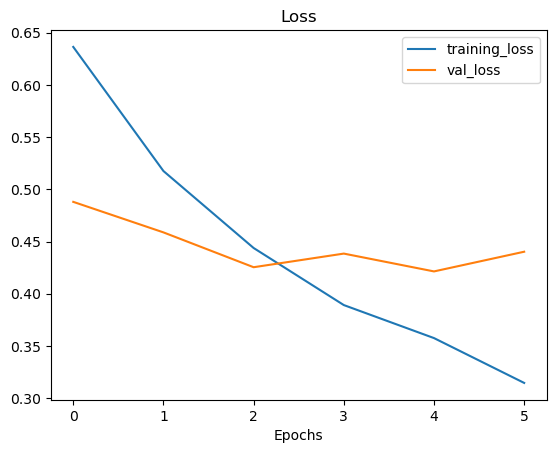

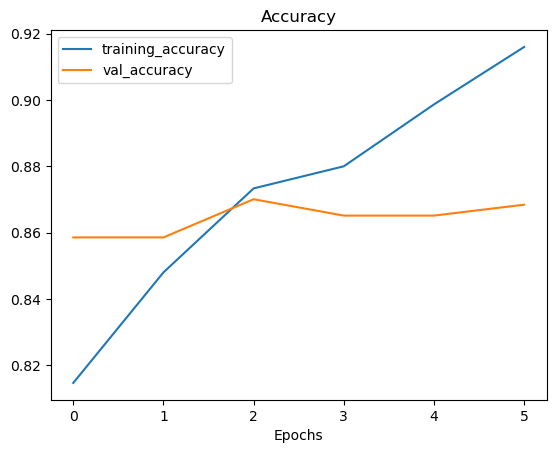

In [54]:
# Check out the loss curve of our fine tuned model
plot_loss_curves(history_fine_10_percent)

The `plot_loss_curve function` works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another

In [55]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs= 5):
    '''
    Comapres two Tensorflow History objects
    '''

    # Get original history measurements
    accuracy = original_history.history['accuracy']
    val_accuracy = original_history.history['val_accuracy']

    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    # Combine original history
    total_accuracy = accuracy + new_history.history['accuracy']
    total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots
    plt.figure(figsize= (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_accuracy, label= 'Total Training Accuracy')
    plt.plot(total_val_accuracy, label= 'Total Testing Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label= 'Total Training Loss Values')
    plt.plot(total_val_loss, label= 'Total Testing Loss Values')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Loss Value")

    plt.tight_layout()

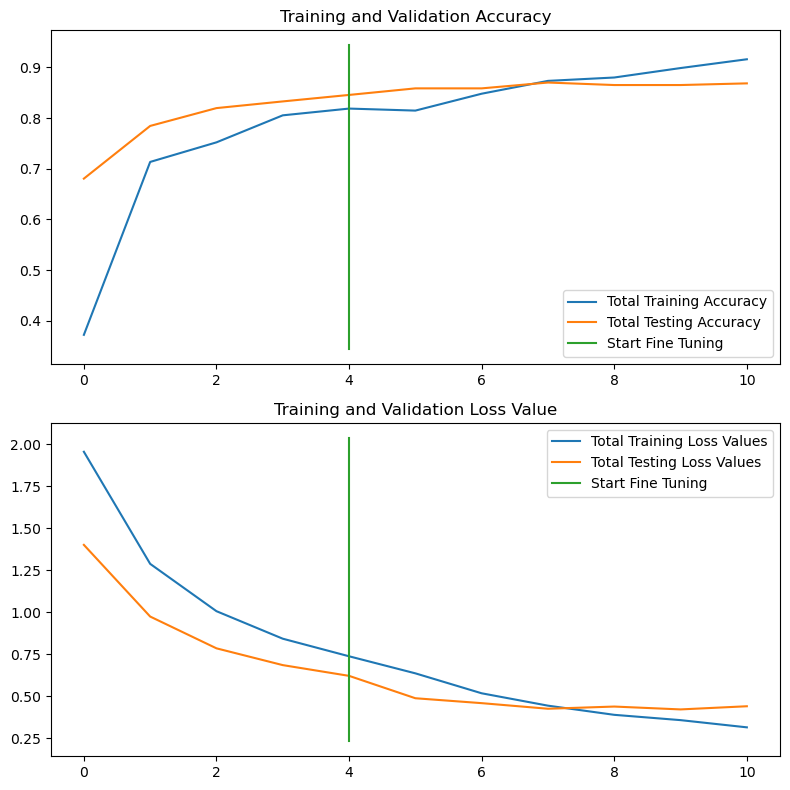

In [56]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_10_percent,
                  initial_epochs= 5)

## Model 4: Fine-tuning and existing model on all the data

# Download and unzip 10 classes of Fodd101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

In [57]:
# Setup training and test dir
TRAIN_DIR_2 = "10_food_classes_all_data/train"
TEST_DIR_2 = "10_food_classes_all_data/test"

In [58]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [59]:
# Setup data inputs
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

test_data_full = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in it is the same as what we've been using for previous experiments

Let's verify

In [60]:
# Evaluate model_2
model_2.evaluate(test_data_full)

79/79 [==============================] - 26s 327ms/step - loss: 0.4281 - accuracy: 0.8632


[0.4281180799007416, 0.8632000088691711]

To train a fine-tuning model we need to revert model_2 back to its feature extraction weights

In [61]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [62]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 33s 414ms/step - loss: 0.6213 - accuracy: 0.8456


[0.6213378310203552, 0.8456000089645386]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% percent of the data with data augmnetation and we saved model's weight using `ModelCheckpoint` Callback
2. Fine-tuned to same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unforzen
3. Saved the results and training logs each time 
4. Reloaded the model from step 1 to do the same steps as stpe 2 except this time we're going to use all of the data

In [63]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_poolonmg_2D True
4 output_layer True


In [64]:
# Let's drill into our base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [65]:
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001),
                metrics= ['accuracy'])

In [66]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [72]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = 10

with tf.device('/device:GPU:0'):
    history_fine_full = model_2.fit(train_data_full,
                                    epochs= fine_tune_epochs,
                                    validation_data= test_data_full,
                                    validation_steps= int(0.25 * len(test_data_full)),
                                    initial_epoch= history_10_percent.epoch[-1],
                                    callbacks= [create_tensorboard_callback('tensorflow_hub', 'full_10_classes_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/full_10_classes_fine_tune/20240215-030308
Epoch 5/10


2024-02-15 03:03:11.829341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 42:46 - loss: 0.8629 - accuracy: 0.7812

2024-02-15 03:03:20.090228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 23:28 - loss: 0.8032 - accuracy: 0.7500

2024-02-15 03:03:26.114918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 18:49 - loss: 0.8267 - accuracy: 0.7292

2024-02-15 03:03:29.939836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 16:58 - loss: 0.8516 - accuracy: 0.7188

2024-02-15 03:03:33.272912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 17:18 - loss: 0.8484 - accuracy: 0.7250

2024-02-15 03:03:38.101452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 15:11 - loss: 0.8422 - accuracy: 0.7240

2024-02-15 03:03:39.956025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 14:51 - loss: 0.8222 - accuracy: 0.7321

2024-02-15 03:03:43.637919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 14:18 - loss: 0.8050 - accuracy: 0.7422

2024-02-15 03:03:46.419677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 13:51 - loss: 0.8256 - accuracy: 0.7431

2024-02-15 03:03:49.438974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 13:53 - loss: 0.7918 - accuracy: 0.7594

2024-02-15 03:03:53.397660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 13:29 - loss: 0.7843 - accuracy: 0.7642

2024-02-15 03:03:56.159846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 13:05 - loss: 0.8045 - accuracy: 0.7578

2024-02-15 03:03:58.991028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 13:19 - loss: 0.8473 - accuracy: 0.7500

2024-02-15 03:04:03.140802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 13:16 - loss: 0.8321 - accuracy: 0.7567

2024-02-15 03:04:06.805496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 13:10 - loss: 0.8040 - accuracy: 0.7688

2024-02-15 03:04:10.250713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 13:07 - loss: 0.7969 - accuracy: 0.7734

2024-02-15 03:04:13.899701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 12:48 - loss: 0.7963 - accuracy: 0.7721

2024-02-15 03:04:16.333283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 12:37 - loss: 0.7845 - accuracy: 0.7760

2024-02-15 03:04:19.262770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 12:19 - loss: 0.7747 - accuracy: 0.7780

2024-02-15 03:04:21.570986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 11:57 - loss: 0.7777 - accuracy: 0.7781

2024-02-15 03:04:23.398217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 12:08 - loss: 0.7878 - accuracy: 0.7738

2024-02-15 03:04:28.024645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 12:07 - loss: 0.7916 - accuracy: 0.7770

2024-02-15 03:04:31.678098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 12:03 - loss: 0.7995 - accuracy: 0.7745

2024-02-15 03:04:35.052137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 11:53 - loss: 0.7876 - accuracy: 0.7760

2024-02-15 03:04:37.747249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 11:47 - loss: 0.8022 - accuracy: 0.7713

2024-02-15 03:04:40.771820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 11:38 - loss: 0.8149 - accuracy: 0.7656

2024-02-15 03:04:43.498790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 11:24 - loss: 0.8151 - accuracy: 0.7616

2024-02-15 03:04:45.471594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 11:17 - loss: 0.8132 - accuracy: 0.7612

2024-02-15 03:04:48.551657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 11:05 - loss: 0.8022 - accuracy: 0.7640

2024-02-15 03:04:50.390428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 10:56 - loss: 0.7969 - accuracy: 0.7656

2024-02-15 03:04:52.800664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 10:53 - loss: 0.7938 - accuracy: 0.7671

2024-02-15 03:04:56.059632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 10:51 - loss: 0.7858 - accuracy: 0.7695

2024-02-15 03:04:59.453923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 10:39 - loss: 0.7877 - accuracy: 0.7680

2024-02-15 03:05:01.206632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 10:32 - loss: 0.7873 - accuracy: 0.7684

2024-02-15 03:05:03.786770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 10:20 - loss: 0.7871 - accuracy: 0.7670

2024-02-15 03:05:05.412132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 10:10 - loss: 0.7792 - accuracy: 0.7682

2024-02-15 03:05:07.369552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 10:02 - loss: 0.7765 - accuracy: 0.7686

2024-02-15 03:05:09.493075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 9:55 - loss: 0.7741 - accuracy: 0.7697 

2024-02-15 03:05:11.794142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 9:44 - loss: 0.7673 - accuracy: 0.7716

2024-02-15 03:05:13.235206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 9:35 - loss: 0.7661 - accuracy: 0.7711

2024-02-15 03:05:15.079440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 9:36 - loss: 0.7615 - accuracy: 0.7721

2024-02-15 03:05:18.713871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 9:35 - loss: 0.7547 - accuracy: 0.7753

2024-02-15 03:05:22.100557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 9:25 - loss: 0.7561 - accuracy: 0.7733

2024-02-15 03:05:23.709954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 9:20 - loss: 0.7537 - accuracy: 0.7727

2024-02-15 03:05:26.166123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 9:15 - loss: 0.7564 - accuracy: 0.7694

2024-02-15 03:05:28.640633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 9:10 - loss: 0.7514 - accuracy: 0.7697

2024-02-15 03:05:30.992599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 9:01 - loss: 0.7481 - accuracy: 0.7706

2024-02-15 03:05:32.333340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 8:52 - loss: 0.7518 - accuracy: 0.7682

2024-02-15 03:05:33.644406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 8:49 - loss: 0.7529 - accuracy: 0.7666

2024-02-15 03:05:36.483780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 8:40 - loss: 0.7516 - accuracy: 0.7675

2024-02-15 03:05:37.878680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 8:34 - loss: 0.7605 - accuracy: 0.7635

2024-02-15 03:05:39.649402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 8:38 - loss: 0.7593 - accuracy: 0.7644

2024-02-15 03:05:44.422390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 8:32 - loss: 0.7545 - accuracy: 0.7653

2024-02-15 03:05:46.301230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 8:26 - loss: 0.7473 - accuracy: 0.7674

2024-02-15 03:05:48.114672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 8:20 - loss: 0.7429 - accuracy: 0.7693

2024-02-15 03:05:49.981028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 8:13 - loss: 0.7405 - accuracy: 0.7690

2024-02-15 03:05:51.692718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 8:10 - loss: 0.7426 - accuracy: 0.7681

2024-02-15 03:05:54.149520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 8:03 - loss: 0.7453 - accuracy: 0.7672

2024-02-15 03:05:55.609671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 7:56 - loss: 0.7405 - accuracy: 0.7685

2024-02-15 03:05:56.848315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 7:49 - loss: 0.7391 - accuracy: 0.7698

2024-02-15 03:05:58.236279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 7:45 - loss: 0.7326 - accuracy: 0.7731

2024-02-15 03:06:00.518741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 7:39 - loss: 0.7341 - accuracy: 0.7707

2024-02-15 03:06:02.051959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 7:34 - loss: 0.7304 - accuracy: 0.7718

2024-02-15 03:06:03.734267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 7:30 - loss: 0.7270 - accuracy: 0.7720

2024-02-15 03:06:05.737802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 7:29 - loss: 0.7232 - accuracy: 0.7736

2024-02-15 03:06:09.266165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 7:27 - loss: 0.7213 - accuracy: 0.7741

2024-02-15 03:06:12.150312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 7:25 - loss: 0.7197 - accuracy: 0.7747

2024-02-15 03:06:14.894582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 7:25 - loss: 0.7179 - accuracy: 0.7753

2024-02-15 03:06:18.625574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 7:22 - loss: 0.7150 - accuracy: 0.7763

2024-02-15 03:06:21.227169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 7:17 - loss: 0.7116 - accuracy: 0.7763

2024-02-15 03:06:22.833842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 7:18 - loss: 0.7147 - accuracy: 0.7760

2024-02-15 03:06:26.889560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 7:14 - loss: 0.7117 - accuracy: 0.7778

2024-02-15 03:06:29.142637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 7:10 - loss: 0.7089 - accuracy: 0.7783

2024-02-15 03:06:31.402983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 7:07 - loss: 0.7063 - accuracy: 0.7796

2024-02-15 03:06:33.916036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 7:02 - loss: 0.7045 - accuracy: 0.7800

2024-02-15 03:06:35.205387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 6:59 - loss: 0.7068 - accuracy: 0.7788

2024-02-15 03:06:37.670277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 6:54 - loss: 0.7062 - accuracy: 0.7780

2024-02-15 03:06:39.353852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 6:51 - loss: 0.7089 - accuracy: 0.7764

2024-02-15 03:06:41.839346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 6:50 - loss: 0.7072 - accuracy: 0.7777

2024-02-15 03:06:45.013016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 6:47 - loss: 0.7070 - accuracy: 0.7766

2024-02-15 03:06:47.438937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 6:43 - loss: 0.7105 - accuracy: 0.7751

2024-02-15 03:06:49.353920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 6:41 - loss: 0.7150 - accuracy: 0.7740

2024-02-15 03:06:52.262469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 6:38 - loss: 0.7150 - accuracy: 0.7726

2024-02-15 03:06:55.062470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 6:33 - loss: 0.7131 - accuracy: 0.7731

2024-02-15 03:06:56.477121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 6:30 - loss: 0.7141 - accuracy: 0.7721

2024-02-15 03:06:58.832850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 6:27 - loss: 0.7126 - accuracy: 0.7718

2024-02-15 03:07:01.207229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 6:25 - loss: 0.7135 - accuracy: 0.7708

2024-02-15 03:07:03.982670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 6:21 - loss: 0.7127 - accuracy: 0.7710

2024-02-15 03:07:05.584712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 6:18 - loss: 0.7095 - accuracy: 0.7721

2024-02-15 03:07:07.783991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 6:13 - loss: 0.7063 - accuracy: 0.7736

2024-02-15 03:07:09.362528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 6:09 - loss: 0.7026 - accuracy: 0.7747

2024-02-15 03:07:10.902260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 6:07 - loss: 0.7008 - accuracy: 0.7745

2024-02-15 03:07:13.800233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 6:03 - loss: 0.6996 - accuracy: 0.7742

2024-02-15 03:07:15.301041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 5:59 - loss: 0.6979 - accuracy: 0.7746

2024-02-15 03:07:16.999179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 5:55 - loss: 0.6961 - accuracy: 0.7757

2024-02-15 03:07:18.856650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 5:51 - loss: 0.6952 - accuracy: 0.7757

2024-02-15 03:07:20.208458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 5:47 - loss: 0.6923 - accuracy: 0.7758

2024-02-15 03:07:22.017071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 5:46 - loss: 0.6897 - accuracy: 0.7765

2024-02-15 03:07:25.119745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 5:42 - loss: 0.6891 - accuracy: 0.7765

2024-02-15 03:07:26.493193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 5:39 - loss: 0.6884 - accuracy: 0.7769

2024-02-15 03:07:29.149589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 5:36 - loss: 0.6902 - accuracy: 0.7760

2024-02-15 03:07:30.886695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 5:34 - loss: 0.6881 - accuracy: 0.7767

2024-02-15 03:07:34.082798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 5:30 - loss: 0.6880 - accuracy: 0.7767

2024-02-15 03:07:35.604034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 5:28 - loss: 0.6869 - accuracy: 0.7767

2024-02-15 03:07:37.875344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 5:24 - loss: 0.6875 - accuracy: 0.7768

2024-02-15 03:07:39.867829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 5:21 - loss: 0.6882 - accuracy: 0.7762

2024-02-15 03:07:41.397288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 5:18 - loss: 0.6881 - accuracy: 0.7763

2024-02-15 03:07:43.947372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 5:17 - loss: 0.6870 - accuracy: 0.7763

2024-02-15 03:07:47.204746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 5:13 - loss: 0.6844 - accuracy: 0.7775

2024-02-15 03:07:48.848196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 5:11 - loss: 0.6820 - accuracy: 0.7784

2024-02-15 03:07:51.123490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 5:07 - loss: 0.6818 - accuracy: 0.7793

2024-02-15 03:07:52.894652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 5:03 - loss: 0.6797 - accuracy: 0.7801

2024-02-15 03:07:54.241738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 5:01 - loss: 0.6825 - accuracy: 0.7790

2024-02-15 03:07:56.514652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 4:59 - loss: 0.6815 - accuracy: 0.7793

2024-02-15 03:07:59.459941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 4:57 - loss: 0.6804 - accuracy: 0.7799

2024-02-15 03:08:02.302123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 4:54 - loss: 0.6819 - accuracy: 0.7794

2024-02-15 03:08:04.188471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 4:50 - loss: 0.6810 - accuracy: 0.7802

2024-02-15 03:08:05.949453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 4:48 - loss: 0.6795 - accuracy: 0.7805

2024-02-15 03:08:08.291959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 4:45 - loss: 0.6765 - accuracy: 0.7815

2024-02-15 03:08:10.038574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 4:43 - loss: 0.6758 - accuracy: 0.7818

2024-02-15 03:08:12.920560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 4:39 - loss: 0.6747 - accuracy: 0.7820

2024-02-15 03:08:14.585776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 4:37 - loss: 0.6741 - accuracy: 0.7820

2024-02-15 03:08:17.090441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 4:33 - loss: 0.6732 - accuracy: 0.7828

2024-02-15 03:08:18.167658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 4:31 - loss: 0.6727 - accuracy: 0.7828

2024-02-15 03:08:21.282044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 4:29 - loss: 0.6713 - accuracy: 0.7837

2024-02-15 03:08:23.976643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 4:26 - loss: 0.6703 - accuracy: 0.7842

2024-02-15 03:08:25.929333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 4:23 - loss: 0.6687 - accuracy: 0.7849

2024-02-15 03:08:27.589861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 4:21 - loss: 0.6691 - accuracy: 0.7854

2024-02-15 03:08:29.840580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 4:18 - loss: 0.6711 - accuracy: 0.7849

2024-02-15 03:08:31.542069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 4:14 - loss: 0.6699 - accuracy: 0.7853

2024-02-15 03:08:33.186654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 4:11 - loss: 0.6683 - accuracy: 0.7860

2024-02-15 03:08:34.706987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 4:09 - loss: 0.6675 - accuracy: 0.7862

2024-02-15 03:08:37.639543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 4:07 - loss: 0.6662 - accuracy: 0.7867

2024-02-15 03:08:39.749770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 4:04 - loss: 0.6698 - accuracy: 0.7854

2024-02-15 03:08:42.148261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 4:02 - loss: 0.6687 - accuracy: 0.7861

2024-02-15 03:08:44.388148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 4:00 - loss: 0.6670 - accuracy: 0.7861

2024-02-15 03:08:47.298124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:57 - loss: 0.6646 - accuracy: 0.7872

2024-02-15 03:08:49.030606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:54 - loss: 0.6651 - accuracy: 0.7867

2024-02-15 03:08:51.098092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:51 - loss: 0.6633 - accuracy: 0.7875

2024-02-15 03:08:52.975486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:49 - loss: 0.6638 - accuracy: 0.7875

2024-02-15 03:08:55.957316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:47 - loss: 0.6630 - accuracy: 0.7875

2024-02-15 03:08:58.260662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:44 - loss: 0.6627 - accuracy: 0.7872

2024-02-15 03:09:00.634552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:41 - loss: 0.6620 - accuracy: 0.7874

2024-02-15 03:09:02.107625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:38 - loss: 0.6605 - accuracy: 0.7873

2024-02-15 03:09:03.884233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:36 - loss: 0.6611 - accuracy: 0.7871

2024-02-15 03:09:06.697672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:35 - loss: 0.6619 - accuracy: 0.7866

2024-02-15 03:09:10.228696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:32 - loss: 0.6626 - accuracy: 0.7864

2024-02-15 03:09:12.539119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:30 - loss: 0.6620 - accuracy: 0.7863

2024-02-15 03:09:15.261028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 3:27 - loss: 0.6632 - accuracy: 0.7863

2024-02-15 03:09:17.205642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 3:24 - loss: 0.6613 - accuracy: 0.7873

2024-02-15 03:09:18.625525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 3:22 - loss: 0.6593 - accuracy: 0.7883

2024-02-15 03:09:20.844584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 3:19 - loss: 0.6598 - accuracy: 0.7884

2024-02-15 03:09:23.194220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 3:17 - loss: 0.6595 - accuracy: 0.7888

2024-02-15 03:09:26.290619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:15 - loss: 0.6587 - accuracy: 0.7888

2024-02-15 03:09:29.266427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:13 - loss: 0.6620 - accuracy: 0.7875

2024-02-15 03:09:31.855129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:10 - loss: 0.6634 - accuracy: 0.7867

2024-02-15 03:09:34.229828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:08 - loss: 0.6640 - accuracy: 0.7864

2024-02-15 03:09:36.160353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:05 - loss: 0.6649 - accuracy: 0.7868

2024-02-15 03:09:37.751392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:02 - loss: 0.6646 - accuracy: 0.7869

2024-02-15 03:09:38.898943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:59 - loss: 0.6660 - accuracy: 0.7861

2024-02-15 03:09:39.866409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:56 - loss: 0.6669 - accuracy: 0.7857

2024-02-15 03:09:41.557581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:54 - loss: 0.6668 - accuracy: 0.7855

2024-02-15 03:09:43.798457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:51 - loss: 0.6670 - accuracy: 0.7855

2024-02-15 03:09:45.841655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:49 - loss: 0.6656 - accuracy: 0.7858

2024-02-15 03:09:48.858074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:46 - loss: 0.6648 - accuracy: 0.7864

2024-02-15 03:09:50.405573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:44 - loss: 0.6667 - accuracy: 0.7860

2024-02-15 03:09:53.078891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:41 - loss: 0.6658 - accuracy: 0.7863

2024-02-15 03:09:55.087343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:39 - loss: 0.6657 - accuracy: 0.7861

2024-02-15 03:09:57.760708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:37 - loss: 0.6651 - accuracy: 0.7862

2024-02-15 03:10:00.575609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:34 - loss: 0.6646 - accuracy: 0.7866

2024-02-15 03:10:01.863255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:32 - loss: 0.6652 - accuracy: 0.7862

2024-02-15 03:10:04.123158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:29 - loss: 0.6657 - accuracy: 0.7862

2024-02-15 03:10:06.342034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:27 - loss: 0.6645 - accuracy: 0.7861

2024-02-15 03:10:08.121577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:24 - loss: 0.6641 - accuracy: 0.7861

2024-02-15 03:10:11.085844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:22 - loss: 0.6629 - accuracy: 0.7868

2024-02-15 03:10:13.556287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:20 - loss: 0.6645 - accuracy: 0.7866

2024-02-15 03:10:15.510783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:17 - loss: 0.6658 - accuracy: 0.7864

2024-02-15 03:10:18.540472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:15 - loss: 0.6658 - accuracy: 0.7867

2024-02-15 03:10:20.364332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:12 - loss: 0.6650 - accuracy: 0.7870

2024-02-15 03:10:22.424567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:10 - loss: 0.6655 - accuracy: 0.7870

2024-02-15 03:10:24.277654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:07 - loss: 0.6657 - accuracy: 0.7875

2024-02-15 03:10:26.402617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:05 - loss: 0.6664 - accuracy: 0.7874

2024-02-15 03:10:28.736015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:02 - loss: 0.6661 - accuracy: 0.7879

2024-02-15 03:10:29.554618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:00 - loss: 0.6656 - accuracy: 0.7879

2024-02-15 03:10:31.242835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 1:58 - loss: 0.6643 - accuracy: 0.7883

2024-02-15 03:10:34.177921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:55 - loss: 0.6643 - accuracy: 0.7883

2024-02-15 03:10:36.731795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:53 - loss: 0.6646 - accuracy: 0.7884

2024-02-15 03:10:38.320766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:50 - loss: 0.6637 - accuracy: 0.7891

2024-02-15 03:10:40.635793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:48 - loss: 0.6641 - accuracy: 0.7887

2024-02-15 03:10:42.812715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:45 - loss: 0.6632 - accuracy: 0.7891

2024-02-15 03:10:43.872102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:43 - loss: 0.6637 - accuracy: 0.7891

2024-02-15 03:10:45.464057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:40 - loss: 0.6653 - accuracy: 0.7887

2024-02-15 03:10:47.314624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:38 - loss: 0.6656 - accuracy: 0.7887

2024-02-15 03:10:49.262447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:36 - loss: 0.6639 - accuracy: 0.7895

2024-02-15 03:10:51.877066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:33 - loss: 0.6642 - accuracy: 0.7894

2024-02-15 03:10:53.935790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:31 - loss: 0.6635 - accuracy: 0.7897

2024-02-15 03:10:56.310799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:29 - loss: 0.6623 - accuracy: 0.7903

2024-02-15 03:10:58.995181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:26 - loss: 0.6618 - accuracy: 0.7902

2024-02-15 03:11:00.611012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:24 - loss: 0.6636 - accuracy: 0.7896

2024-02-15 03:11:02.835417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:21 - loss: 0.6625 - accuracy: 0.7900

2024-02-15 03:11:05.125853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:19 - loss: 0.6610 - accuracy: 0.7906

2024-02-15 03:11:07.358134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:16 - loss: 0.6603 - accuracy: 0.7907

2024-02-15 03:11:08.720470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:14 - loss: 0.6591 - accuracy: 0.7909

2024-02-15 03:11:10.489465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:12 - loss: 0.6594 - accuracy: 0.7909

2024-02-15 03:11:12.613554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:09 - loss: 0.6589 - accuracy: 0.7905

2024-02-15 03:11:15.593193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:07 - loss: 0.6604 - accuracy: 0.7900

2024-02-15 03:11:17.200130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:05 - loss: 0.6602 - accuracy: 0.7899

2024-02-15 03:11:19.710217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:02 - loss: 0.6595 - accuracy: 0.7898

2024-02-15 03:11:22.161872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:00 - loss: 0.6597 - accuracy: 0.7896

2024-02-15 03:11:25.059785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 58s - loss: 0.6586 - accuracy: 0.7899 

2024-02-15 03:11:28.622200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 56s - loss: 0.6593 - accuracy: 0.7894

2024-02-15 03:11:31.527427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 53s - loss: 0.6578 - accuracy: 0.7898

2024-02-15 03:11:33.419670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 51s - loss: 0.6583 - accuracy: 0.7892

2024-02-15 03:11:35.439799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 49s - loss: 0.6587 - accuracy: 0.7891

2024-02-15 03:11:37.926491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 46s - loss: 0.6576 - accuracy: 0.7895

2024-02-15 03:11:40.447258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 44s - loss: 0.6575 - accuracy: 0.7896

2024-02-15 03:11:43.075207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 42s - loss: 0.6575 - accuracy: 0.7896

2024-02-15 03:11:44.442709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 39s - loss: 0.6560 - accuracy: 0.7901

2024-02-15 03:11:46.761115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 37s - loss: 0.6553 - accuracy: 0.7904

2024-02-15 03:11:49.529303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 35s - loss: 0.6547 - accuracy: 0.7909

2024-02-15 03:11:51.259404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 32s - loss: 0.6542 - accuracy: 0.7909

2024-02-15 03:11:52.365077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 30s - loss: 0.6545 - accuracy: 0.7911

2024-02-15 03:11:54.859280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 27s - loss: 0.6538 - accuracy: 0.7912

2024-02-15 03:11:56.423270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 25s - loss: 0.6531 - accuracy: 0.7917

2024-02-15 03:11:59.154262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 23s - loss: 0.6518 - accuracy: 0.7922

2024-02-15 03:12:01.210830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 20s - loss: 0.6495 - accuracy: 0.7930

2024-02-15 03:12:03.009053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 18s - loss: 0.6493 - accuracy: 0.7932

2024-02-15 03:12:04.778815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 16s - loss: 0.6492 - accuracy: 0.7930

2024-02-15 03:12:07.704293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 13s - loss: 0.6498 - accuracy: 0.7933

2024-02-15 03:12:09.043674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 11s - loss: 0.6487 - accuracy: 0.7936

2024-02-15 03:12:10.398912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 9s - loss: 0.6476 - accuracy: 0.7941 

2024-02-15 03:12:12.311018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 6s - loss: 0.6478 - accuracy: 0.7940

2024-02-15 03:12:13.732612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 4s - loss: 0.6468 - accuracy: 0.7944

2024-02-15 03:12:15.968837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.6469 - accuracy: 0.7943

2024-02-15 03:12:18.472945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 577s 2s/step - loss: 0.6464 - accuracy: 0.7945 - val_loss: 0.3375 - val_accuracy: 0.8964
Epoch 6/10


2024-02-15 03:12:45.899443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 6:36 - loss: 0.2408 - accuracy: 0.9375

2024-02-15 03:12:47.594361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 11:50 - loss: 0.4294 - accuracy: 0.8594

2024-02-15 03:12:50.642286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 9:31 - loss: 0.4900 - accuracy: 0.8542 

2024-02-15 03:12:52.516674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 8:20 - loss: 0.4425 - accuracy: 0.8672

2024-02-15 03:12:54.086113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 7:42 - loss: 0.4953 - accuracy: 0.8562

2024-02-15 03:12:55.637543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 8:13 - loss: 0.5554 - accuracy: 0.8542

2024-02-15 03:12:58.377535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 8:48 - loss: 0.5621 - accuracy: 0.8527

2024-02-15 03:13:01.488875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 8:55 - loss: 0.5991 - accuracy: 0.8359

2024-02-15 03:13:04.096507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 8:41 - loss: 0.6291 - accuracy: 0.8264

2024-02-15 03:13:06.045976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 10:05 - loss: 0.6130 - accuracy: 0.8313

2024-02-15 03:13:11.820784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 10:10 - loss: 0.5968 - accuracy: 0.8324

2024-02-15 03:13:14.864871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 9:42 - loss: 0.5809 - accuracy: 0.8385 

2024-02-15 03:13:16.331931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 9:20 - loss: 0.5788 - accuracy: 0.8365

2024-02-15 03:13:17.878891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 9:06 - loss: 0.5838 - accuracy: 0.8304

2024-02-15 03:13:19.771871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 9:03 - loss: 0.5742 - accuracy: 0.8333

2024-02-15 03:13:22.146415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 8:59 - loss: 0.5795 - accuracy: 0.8262

2024-02-15 03:13:24.554580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 8:43 - loss: 0.5977 - accuracy: 0.8199

2024-02-15 03:13:26.002181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 8:31 - loss: 0.5938 - accuracy: 0.8229

2024-02-15 03:13:27.624881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 8:22 - loss: 0.5979 - accuracy: 0.8224

2024-02-15 03:13:29.441171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 8:26 - loss: 0.5928 - accuracy: 0.8219

2024-02-15 03:13:32.363332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 8:32 - loss: 0.6025 - accuracy: 0.8185

2024-02-15 03:13:35.520456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 8:23 - loss: 0.5954 - accuracy: 0.8210

2024-02-15 03:13:37.231268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 8:16 - loss: 0.5978 - accuracy: 0.8179

2024-02-15 03:13:39.161481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 8:23 - loss: 0.6047 - accuracy: 0.8138

2024-02-15 03:13:42.421644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 8:13 - loss: 0.5995 - accuracy: 0.8138

2024-02-15 03:13:43.948573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 8:14 - loss: 0.5956 - accuracy: 0.8125

2024-02-15 03:13:46.724178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 8:04 - loss: 0.5994 - accuracy: 0.8113

2024-02-15 03:13:48.197760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 8:02 - loss: 0.5958 - accuracy: 0.8136

2024-02-15 03:13:50.513212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 8:03 - loss: 0.5994 - accuracy: 0.8136

2024-02-15 03:13:53.338071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 8:00 - loss: 0.5911 - accuracy: 0.8146

2024-02-15 03:13:55.624333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 8:01 - loss: 0.5866 - accuracy: 0.8145

2024-02-15 03:13:58.443238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 7:57 - loss: 0.5882 - accuracy: 0.8135

2024-02-15 03:14:00.581193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 7:59 - loss: 0.5821 - accuracy: 0.8163

2024-02-15 03:14:03.501866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 7:58 - loss: 0.5774 - accuracy: 0.8180

2024-02-15 03:14:06.215165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 7:52 - loss: 0.5788 - accuracy: 0.8188

2024-02-15 03:14:07.883754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 7:50 - loss: 0.5710 - accuracy: 0.8220

2024-02-15 03:14:10.427206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 7:53 - loss: 0.5746 - accuracy: 0.8201

2024-02-15 03:14:13.657025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 7:51 - loss: 0.5709 - accuracy: 0.8215

2024-02-15 03:14:16.102705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 7:49 - loss: 0.5668 - accuracy: 0.8237

2024-02-15 03:14:18.594025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 7:47 - loss: 0.5682 - accuracy: 0.8227

2024-02-15 03:14:21.072532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 7:49 - loss: 0.5757 - accuracy: 0.8194

2024-02-15 03:14:24.464919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 7:47 - loss: 0.5773 - accuracy: 0.8185

2024-02-15 03:14:26.837713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 7:46 - loss: 0.5763 - accuracy: 0.8198

2024-02-15 03:14:29.704267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 7:45 - loss: 0.5712 - accuracy: 0.8210

2024-02-15 03:14:32.401242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 7:38 - loss: 0.5689 - accuracy: 0.8222

2024-02-15 03:14:33.679604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 7:37 - loss: 0.5687 - accuracy: 0.8227

2024-02-15 03:14:36.517861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 7:33 - loss: 0.5701 - accuracy: 0.8218

2024-02-15 03:14:38.616109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 7:32 - loss: 0.5665 - accuracy: 0.8216

2024-02-15 03:14:41.272086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 7:27 - loss: 0.5659 - accuracy: 0.8214

2024-02-15 03:14:43.186908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 7:25 - loss: 0.5648 - accuracy: 0.8213

2024-02-15 03:14:45.716777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 7:23 - loss: 0.5674 - accuracy: 0.8192

2024-02-15 03:14:48.056273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 7:20 - loss: 0.5637 - accuracy: 0.8209

2024-02-15 03:14:50.280306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 7:17 - loss: 0.5587 - accuracy: 0.8225

2024-02-15 03:14:52.531810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 7:17 - loss: 0.5548 - accuracy: 0.8241

2024-02-15 03:14:55.592574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 7:12 - loss: 0.5536 - accuracy: 0.8256

2024-02-15 03:14:57.243928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 7:07 - loss: 0.5513 - accuracy: 0.8259

2024-02-15 03:14:58.986380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 7:01 - loss: 0.5538 - accuracy: 0.8246

2024-02-15 03:15:00.236097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 7:00 - loss: 0.5563 - accuracy: 0.8244

2024-02-15 03:15:03.096639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 6:56 - loss: 0.5554 - accuracy: 0.8252

2024-02-15 03:15:04.796504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 6:52 - loss: 0.5556 - accuracy: 0.8245

2024-02-15 03:15:06.685418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 6:51 - loss: 0.5580 - accuracy: 0.8233

2024-02-15 03:15:09.542330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 6:46 - loss: 0.5557 - accuracy: 0.8241

2024-02-15 03:15:10.776839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 6:43 - loss: 0.5543 - accuracy: 0.8244

2024-02-15 03:15:13.062235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 6:38 - loss: 0.5553 - accuracy: 0.8242

2024-02-15 03:15:14.536041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 6:37 - loss: 0.5505 - accuracy: 0.8264

2024-02-15 03:15:17.168805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 6:33 - loss: 0.5572 - accuracy: 0.8262

2024-02-15 03:15:18.844030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 6:31 - loss: 0.5628 - accuracy: 0.8251

2024-02-15 03:15:21.507606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 6:27 - loss: 0.5601 - accuracy: 0.8258

2024-02-15 03:15:23.076719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 6:24 - loss: 0.5563 - accuracy: 0.8279

2024-02-15 03:15:25.113582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 6:23 - loss: 0.5557 - accuracy: 0.8290

2024-02-15 03:15:27.879118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 6:20 - loss: 0.5549 - accuracy: 0.8288

2024-02-15 03:15:29.861752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 6:20 - loss: 0.5534 - accuracy: 0.8286

2024-02-15 03:15:33.209491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 6:16 - loss: 0.5545 - accuracy: 0.8283

2024-02-15 03:15:34.835773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 6:13 - loss: 0.5524 - accuracy: 0.8294

2024-02-15 03:15:36.842865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 6:11 - loss: 0.5513 - accuracy: 0.8292

2024-02-15 03:15:39.387550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 6:08 - loss: 0.5511 - accuracy: 0.8289

2024-02-15 03:15:41.382884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 6:08 - loss: 0.5492 - accuracy: 0.8295

2024-02-15 03:15:44.813156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 6:04 - loss: 0.5497 - accuracy: 0.8289

2024-02-15 03:15:46.267571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 6:02 - loss: 0.5550 - accuracy: 0.8275

2024-02-15 03:15:49.038642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 6:02 - loss: 0.5549 - accuracy: 0.8277

2024-02-15 03:15:52.322306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 6:01 - loss: 0.5568 - accuracy: 0.8268

2024-02-15 03:15:55.193458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 5:56 - loss: 0.5548 - accuracy: 0.8266

2024-02-15 03:15:56.462642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 5:55 - loss: 0.5536 - accuracy: 0.8264

2024-02-15 03:15:59.493613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 5:54 - loss: 0.5551 - accuracy: 0.8259

2024-02-15 03:16:02.181749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 5:51 - loss: 0.5567 - accuracy: 0.8257

2024-02-15 03:16:04.580200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 5:48 - loss: 0.5572 - accuracy: 0.8263

2024-02-15 03:16:06.395321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 5:47 - loss: 0.5576 - accuracy: 0.8261

2024-02-15 03:16:09.303165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 5:44 - loss: 0.5549 - accuracy: 0.8278

2024-02-15 03:16:11.305606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 5:41 - loss: 0.5526 - accuracy: 0.8283

2024-02-15 03:16:13.182388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 5:38 - loss: 0.5500 - accuracy: 0.8288

2024-02-15 03:16:15.468377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 5:37 - loss: 0.5502 - accuracy: 0.8286

2024-02-15 03:16:18.744722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 5:36 - loss: 0.5474 - accuracy: 0.8291

2024-02-15 03:16:21.619737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 5:35 - loss: 0.5458 - accuracy: 0.8303

2024-02-15 03:16:25.209022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 5:33 - loss: 0.5455 - accuracy: 0.8301

2024-02-15 03:16:27.419348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 5:31 - loss: 0.5428 - accuracy: 0.8309

2024-02-15 03:16:29.932576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 5:29 - loss: 0.5411 - accuracy: 0.8314

2024-02-15 03:16:32.739609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 5:27 - loss: 0.5384 - accuracy: 0.8322

2024-02-15 03:16:35.238054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 5:25 - loss: 0.5397 - accuracy: 0.8320

2024-02-15 03:16:37.887404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 5:21 - loss: 0.5383 - accuracy: 0.8324

2024-02-15 03:16:39.596995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 5:18 - loss: 0.5396 - accuracy: 0.8325

2024-02-15 03:16:41.286807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 5:16 - loss: 0.5425 - accuracy: 0.8317

2024-02-15 03:16:43.657169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 5:14 - loss: 0.5425 - accuracy: 0.8318

2024-02-15 03:16:46.087529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 5:11 - loss: 0.5407 - accuracy: 0.8322

2024-02-15 03:16:48.390785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 5:09 - loss: 0.5424 - accuracy: 0.8320

2024-02-15 03:16:50.660349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 5:07 - loss: 0.5442 - accuracy: 0.8318

2024-02-15 03:16:53.448393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 5:05 - loss: 0.5436 - accuracy: 0.8320

2024-02-15 03:16:56.380876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 5:03 - loss: 0.5454 - accuracy: 0.8318

2024-02-15 03:16:58.997093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 5:01 - loss: 0.5451 - accuracy: 0.8316

2024-02-15 03:17:01.935343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 4:59 - loss: 0.5451 - accuracy: 0.8317

2024-02-15 03:17:04.333248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 4:57 - loss: 0.5434 - accuracy: 0.8324

2024-02-15 03:17:06.844829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 4:54 - loss: 0.5433 - accuracy: 0.8319

2024-02-15 03:17:08.473575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 4:51 - loss: 0.5426 - accuracy: 0.8320

2024-02-15 03:17:11.056828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 4:49 - loss: 0.5431 - accuracy: 0.8316

2024-02-15 03:17:13.526038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 4:46 - loss: 0.5415 - accuracy: 0.8322

2024-02-15 03:17:15.268621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 4:44 - loss: 0.5439 - accuracy: 0.8315

2024-02-15 03:17:17.433261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 4:41 - loss: 0.5426 - accuracy: 0.8316

2024-02-15 03:17:19.282475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 4:38 - loss: 0.5402 - accuracy: 0.8325

2024-02-15 03:17:21.454657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 4:36 - loss: 0.5388 - accuracy: 0.8329

2024-02-15 03:17:24.357174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 4:34 - loss: 0.5391 - accuracy: 0.8330

2024-02-15 03:17:27.044806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 4:32 - loss: 0.5397 - accuracy: 0.8328

2024-02-15 03:17:29.712100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 4:31 - loss: 0.5396 - accuracy: 0.8329

2024-02-15 03:17:32.957083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 4:28 - loss: 0.5377 - accuracy: 0.8332

2024-02-15 03:17:35.619035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 4:26 - loss: 0.5371 - accuracy: 0.8331

2024-02-15 03:17:37.933149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 4:24 - loss: 0.5368 - accuracy: 0.8327

2024-02-15 03:17:40.285496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 4:21 - loss: 0.5361 - accuracy: 0.8325

2024-02-15 03:17:42.519819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 4:19 - loss: 0.5371 - accuracy: 0.8321

2024-02-15 03:17:44.706810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 4:16 - loss: 0.5372 - accuracy: 0.8322

2024-02-15 03:17:46.302678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 4:13 - loss: 0.5368 - accuracy: 0.8318

2024-02-15 03:17:48.779954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 4:11 - loss: 0.5377 - accuracy: 0.8314

2024-02-15 03:17:51.612162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 4:09 - loss: 0.5389 - accuracy: 0.8310

2024-02-15 03:17:53.755800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 4:06 - loss: 0.5372 - accuracy: 0.8313

2024-02-15 03:17:55.944442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 4:04 - loss: 0.5387 - accuracy: 0.8310

2024-02-15 03:17:58.444422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 4:02 - loss: 0.5405 - accuracy: 0.8301

2024-02-15 03:18:01.353381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 3:59 - loss: 0.5397 - accuracy: 0.8302

2024-02-15 03:18:03.492263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 3:58 - loss: 0.5390 - accuracy: 0.8303

2024-02-15 03:18:07.424589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 3:57 - loss: 0.5374 - accuracy: 0.8311

2024-02-15 03:18:10.776091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:55 - loss: 0.5361 - accuracy: 0.8317

2024-02-15 03:18:13.937750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:52 - loss: 0.5352 - accuracy: 0.8320

2024-02-15 03:18:15.862093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:50 - loss: 0.5353 - accuracy: 0.8325

2024-02-15 03:18:18.344775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:47 - loss: 0.5366 - accuracy: 0.8317

2024-02-15 03:18:21.104646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:45 - loss: 0.5350 - accuracy: 0.8322

2024-02-15 03:18:23.657897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:43 - loss: 0.5349 - accuracy: 0.8321

2024-02-15 03:18:25.863385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:40 - loss: 0.5350 - accuracy: 0.8319

2024-02-15 03:18:28.661176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:38 - loss: 0.5334 - accuracy: 0.8327

2024-02-15 03:18:30.952409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:36 - loss: 0.5340 - accuracy: 0.8321

2024-02-15 03:18:33.759694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:33 - loss: 0.5347 - accuracy: 0.8322

2024-02-15 03:18:35.810494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:31 - loss: 0.5363 - accuracy: 0.8321

2024-02-15 03:18:39.192628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:29 - loss: 0.5357 - accuracy: 0.8321

2024-02-15 03:18:40.736537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 3:26 - loss: 0.5334 - accuracy: 0.8326

2024-02-15 03:18:43.218657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 3:24 - loss: 0.5323 - accuracy: 0.8331

2024-02-15 03:18:46.046726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 3:21 - loss: 0.5337 - accuracy: 0.8324

2024-02-15 03:18:48.053377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 3:19 - loss: 0.5347 - accuracy: 0.8322

2024-02-15 03:18:49.906443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 3:16 - loss: 0.5342 - accuracy: 0.8323

2024-02-15 03:18:51.864011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:13 - loss: 0.5343 - accuracy: 0.8324

2024-02-15 03:18:54.027031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:11 - loss: 0.5345 - accuracy: 0.8325

2024-02-15 03:18:56.676477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:08 - loss: 0.5341 - accuracy: 0.8327

2024-02-15 03:18:58.314235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:06 - loss: 0.5341 - accuracy: 0.8322

2024-02-15 03:19:00.436938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:04 - loss: 0.5344 - accuracy: 0.8323

2024-02-15 03:19:03.650170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:01 - loss: 0.5367 - accuracy: 0.8314

2024-02-15 03:19:05.744426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:59 - loss: 0.5371 - accuracy: 0.8313

2024-02-15 03:19:07.657019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:56 - loss: 0.5373 - accuracy: 0.8317

2024-02-15 03:19:10.111290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:54 - loss: 0.5377 - accuracy: 0.8316

2024-02-15 03:19:12.495002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:52 - loss: 0.5382 - accuracy: 0.8315

2024-02-15 03:19:14.925883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:49 - loss: 0.5367 - accuracy: 0.8319

2024-02-15 03:19:16.795762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:47 - loss: 0.5359 - accuracy: 0.8320

2024-02-15 03:19:20.345080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:45 - loss: 0.5375 - accuracy: 0.8309

2024-02-15 03:19:22.629400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:42 - loss: 0.5381 - accuracy: 0.8308

2024-02-15 03:19:25.016087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:40 - loss: 0.5371 - accuracy: 0.8313

2024-02-15 03:19:26.811295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:37 - loss: 0.5359 - accuracy: 0.8315

2024-02-15 03:19:29.635525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:35 - loss: 0.5383 - accuracy: 0.8305

2024-02-15 03:19:31.516004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:32 - loss: 0.5384 - accuracy: 0.8300

2024-02-15 03:19:33.974041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:30 - loss: 0.5384 - accuracy: 0.8299

2024-02-15 03:19:36.564948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:28 - loss: 0.5375 - accuracy: 0.8300

2024-02-15 03:19:38.869942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:25 - loss: 0.5387 - accuracy: 0.8296

2024-02-15 03:19:40.779968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:23 - loss: 0.5387 - accuracy: 0.8295

2024-02-15 03:19:43.310469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:21 - loss: 0.5393 - accuracy: 0.8290

2024-02-15 03:19:46.090242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:18 - loss: 0.5398 - accuracy: 0.8287

2024-02-15 03:19:49.144681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:16 - loss: 0.5389 - accuracy: 0.8290

2024-02-15 03:19:51.459150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:14 - loss: 0.5390 - accuracy: 0.8291

2024-02-15 03:19:53.768161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:11 - loss: 0.5389 - accuracy: 0.8286

2024-02-15 03:19:56.798989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:09 - loss: 0.5384 - accuracy: 0.8289

2024-02-15 03:19:59.261065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:07 - loss: 0.5371 - accuracy: 0.8293

2024-02-15 03:20:02.954505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:05 - loss: 0.5375 - accuracy: 0.8289

2024-02-15 03:20:05.630518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:02 - loss: 0.5374 - accuracy: 0.8290

2024-02-15 03:20:08.484565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 2:00 - loss: 0.5376 - accuracy: 0.8289

2024-02-15 03:20:11.303948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:58 - loss: 0.5387 - accuracy: 0.8290

2024-02-15 03:20:14.028649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:55 - loss: 0.5394 - accuracy: 0.8289

2024-02-15 03:20:16.161415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:53 - loss: 0.5384 - accuracy: 0.8291

2024-02-15 03:20:19.187568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:51 - loss: 0.5380 - accuracy: 0.8292

2024-02-15 03:20:21.743415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:48 - loss: 0.5375 - accuracy: 0.8294

2024-02-15 03:20:24.523057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:46 - loss: 0.5380 - accuracy: 0.8297

2024-02-15 03:20:27.003528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:43 - loss: 0.5386 - accuracy: 0.8299

2024-02-15 03:20:29.257102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:41 - loss: 0.5372 - accuracy: 0.8301

2024-02-15 03:20:31.142610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:39 - loss: 0.5380 - accuracy: 0.8297

2024-02-15 03:20:34.252436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:36 - loss: 0.5392 - accuracy: 0.8293

2024-02-15 03:20:36.773851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:34 - loss: 0.5386 - accuracy: 0.8294

2024-02-15 03:20:38.720112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:31 - loss: 0.5384 - accuracy: 0.8296

2024-02-15 03:20:41.606932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:29 - loss: 0.5388 - accuracy: 0.8295

2024-02-15 03:20:44.546856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:27 - loss: 0.5394 - accuracy: 0.8295

2024-02-15 03:20:46.860116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:24 - loss: 0.5390 - accuracy: 0.8294

2024-02-15 03:20:49.489696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:22 - loss: 0.5382 - accuracy: 0.8293

2024-02-15 03:20:52.363304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:20 - loss: 0.5394 - accuracy: 0.8291

2024-02-15 03:20:54.933243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:17 - loss: 0.5386 - accuracy: 0.8293

2024-02-15 03:20:56.966536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:15 - loss: 0.5391 - accuracy: 0.8289

2024-02-15 03:20:58.976192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:12 - loss: 0.5392 - accuracy: 0.8290

2024-02-15 03:21:01.328508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:10 - loss: 0.5382 - accuracy: 0.8293

2024-02-15 03:21:03.471066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:07 - loss: 0.5391 - accuracy: 0.8291

2024-02-15 03:21:05.649269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:05 - loss: 0.5388 - accuracy: 0.8292

2024-02-15 03:21:07.727946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:02 - loss: 0.5402 - accuracy: 0.8283

2024-02-15 03:21:10.531426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 1:00 - loss: 0.5399 - accuracy: 0.8284

2024-02-15 03:21:13.110523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 58s - loss: 0.5394 - accuracy: 0.8285 

2024-02-15 03:21:15.472532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 55s - loss: 0.5381 - accuracy: 0.8290

2024-02-15 03:21:18.790824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 53s - loss: 0.5372 - accuracy: 0.8292

2024-02-15 03:21:21.900671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 50s - loss: 0.5363 - accuracy: 0.8296

2024-02-15 03:21:24.516679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 48s - loss: 0.5369 - accuracy: 0.8294

2024-02-15 03:21:26.949106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 46s - loss: 0.5374 - accuracy: 0.8294

2024-02-15 03:21:29.614662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 43s - loss: 0.5368 - accuracy: 0.8296

2024-02-15 03:21:32.396976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 41s - loss: 0.5359 - accuracy: 0.8301

2024-02-15 03:21:34.578653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 38s - loss: 0.5349 - accuracy: 0.8306

2024-02-15 03:21:37.066960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 36s - loss: 0.5351 - accuracy: 0.8305

2024-02-15 03:21:39.675781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 34s - loss: 0.5339 - accuracy: 0.8307

2024-02-15 03:21:42.503822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 31s - loss: 0.5347 - accuracy: 0.8305

2024-02-15 03:21:44.290599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 29s - loss: 0.5344 - accuracy: 0.8303

2024-02-15 03:21:46.209998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 26s - loss: 0.5345 - accuracy: 0.8299

2024-02-15 03:21:50.041473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 24s - loss: 0.5335 - accuracy: 0.8303

2024-02-15 03:21:52.506855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 21s - loss: 0.5345 - accuracy: 0.8301

2024-02-15 03:21:55.016616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 19s - loss: 0.5343 - accuracy: 0.8303

2024-02-15 03:21:56.754459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 17s - loss: 0.5337 - accuracy: 0.8306

2024-02-15 03:21:59.676227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 14s - loss: 0.5331 - accuracy: 0.8308

2024-02-15 03:22:03.021853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 12s - loss: 0.5328 - accuracy: 0.8310

2024-02-15 03:22:06.136734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 9s - loss: 0.5326 - accuracy: 0.8308 

2024-02-15 03:22:08.897635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 7s - loss: 0.5316 - accuracy: 0.8311

2024-02-15 03:22:11.582096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 4s - loss: 0.5310 - accuracy: 0.8311

2024-02-15 03:22:14.126170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.5304 - accuracy: 0.8313

2024-02-15 03:22:16.605098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 594s 3s/step - loss: 0.5303 - accuracy: 0.8313 - val_loss: 0.3030 - val_accuracy: 0.9030
Epoch 7/10


2024-02-15 03:22:40.376834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 11:40 - loss: 0.6900 - accuracy: 0.8438

2024-02-15 03:22:43.402673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 9:59 - loss: 0.6430 - accuracy: 0.8281 

2024-02-15 03:22:45.953880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 12:03 - loss: 0.5704 - accuracy: 0.8125

2024-02-15 03:22:49.607169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 11:12 - loss: 0.5331 - accuracy: 0.8359

2024-02-15 03:22:52.106330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 11:19 - loss: 0.5351 - accuracy: 0.8250

2024-02-15 03:22:55.184298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 11:14 - loss: 0.5395 - accuracy: 0.8229

2024-02-15 03:22:58.109879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 10:35 - loss: 0.5123 - accuracy: 0.8348

2024-02-15 03:23:00.084995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 10:47 - loss: 0.4915 - accuracy: 0.8477

2024-02-15 03:23:03.328049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 10:30 - loss: 0.4830 - accuracy: 0.8472

2024-02-15 03:23:05.717039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 10:15 - loss: 0.5000 - accuracy: 0.8438

2024-02-15 03:23:07.973733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 10:16 - loss: 0.4908 - accuracy: 0.8466

2024-02-15 03:23:10.899652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 10:09 - loss: 0.4912 - accuracy: 0.8464

2024-02-15 03:23:13.410301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 10:06 - loss: 0.5058 - accuracy: 0.8438

2024-02-15 03:23:16.177577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 10:04 - loss: 0.5092 - accuracy: 0.8438

2024-02-15 03:23:18.923506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 10:04 - loss: 0.5139 - accuracy: 0.8417

2024-02-15 03:23:21.848504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 9:53 - loss: 0.5371 - accuracy: 0.8320 

2024-02-15 03:23:24.047023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 9:55 - loss: 0.5323 - accuracy: 0.8327

2024-02-15 03:23:27.071529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 9:50 - loss: 0.5310 - accuracy: 0.8351

2024-02-15 03:23:29.614093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 9:51 - loss: 0.5410 - accuracy: 0.8273

2024-02-15 03:23:32.695875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 9:45 - loss: 0.5440 - accuracy: 0.8281

2024-02-15 03:23:35.089608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 9:32 - loss: 0.5420 - accuracy: 0.8304

2024-02-15 03:23:36.857973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 9:28 - loss: 0.5459 - accuracy: 0.8295

2024-02-15 03:23:39.379630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 9:27 - loss: 0.5512 - accuracy: 0.8234

2024-02-15 03:23:42.224157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 9:37 - loss: 0.5485 - accuracy: 0.8242

2024-02-15 03:23:46.316765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 9:33 - loss: 0.5451 - accuracy: 0.8225

2024-02-15 03:23:48.893433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 9:35 - loss: 0.5556 - accuracy: 0.8185

2024-02-15 03:23:52.250146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 9:30 - loss: 0.5588 - accuracy: 0.8160

2024-02-15 03:23:54.710917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 9:24 - loss: 0.5587 - accuracy: 0.8147

2024-02-15 03:23:56.987988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 9:14 - loss: 0.5527 - accuracy: 0.8168

2024-02-15 03:23:58.740496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 9:16 - loss: 0.5462 - accuracy: 0.8198

2024-02-15 03:24:02.137566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 9:12 - loss: 0.5354 - accuracy: 0.8226

2024-02-15 03:24:04.597675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 9:12 - loss: 0.5382 - accuracy: 0.8242

2024-02-15 03:24:07.723213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 9:15 - loss: 0.5365 - accuracy: 0.8258

2024-02-15 03:24:11.407232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 9:11 - loss: 0.5405 - accuracy: 0.8254

2024-02-15 03:24:13.889874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 9:06 - loss: 0.5347 - accuracy: 0.8277

2024-02-15 03:24:16.280332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 9:02 - loss: 0.5352 - accuracy: 0.8264

2024-02-15 03:24:18.824902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 8:58 - loss: 0.5354 - accuracy: 0.8277

2024-02-15 03:24:21.227934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 8:53 - loss: 0.5387 - accuracy: 0.8273

2024-02-15 03:24:23.615970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 8:49 - loss: 0.5322 - accuracy: 0.8293

2024-02-15 03:24:26.091378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 8:46 - loss: 0.5258 - accuracy: 0.8320

2024-02-15 03:24:28.773639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 8:43 - loss: 0.5252 - accuracy: 0.8323

2024-02-15 03:24:31.325526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 8:40 - loss: 0.5325 - accuracy: 0.8296

2024-02-15 03:24:34.204173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 8:42 - loss: 0.5265 - accuracy: 0.8328

2024-02-15 03:24:37.758438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 8:39 - loss: 0.5241 - accuracy: 0.8331

2024-02-15 03:24:40.224714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 8:36 - loss: 0.5193 - accuracy: 0.8340

2024-02-15 03:24:42.987777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 8:33 - loss: 0.5207 - accuracy: 0.8329

2024-02-15 03:24:45.602123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 8:33 - loss: 0.5212 - accuracy: 0.8331

2024-02-15 03:24:49.109715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 8:27 - loss: 0.5223 - accuracy: 0.8320

2024-02-15 03:24:51.041991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 8:26 - loss: 0.5221 - accuracy: 0.8316

2024-02-15 03:24:54.177038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 8:23 - loss: 0.5228 - accuracy: 0.8313

2024-02-15 03:24:56.692830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 8:21 - loss: 0.5223 - accuracy: 0.8321

2024-02-15 03:24:59.616659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 8:20 - loss: 0.5224 - accuracy: 0.8323

2024-02-15 03:25:02.855987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 8:18 - loss: 0.5226 - accuracy: 0.8314

2024-02-15 03:25:05.682832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 8:14 - loss: 0.5188 - accuracy: 0.8328

2024-02-15 03:25:08.206716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 8:14 - loss: 0.5146 - accuracy: 0.8347

2024-02-15 03:25:11.812951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 8:09 - loss: 0.5096 - accuracy: 0.8371

2024-02-15 03:25:13.712232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 8:05 - loss: 0.5099 - accuracy: 0.8366

2024-02-15 03:25:15.969512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 8:01 - loss: 0.5114 - accuracy: 0.8367

2024-02-15 03:25:18.532281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 7:57 - loss: 0.5100 - accuracy: 0.8374

2024-02-15 03:25:20.828203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 7:56 - loss: 0.5107 - accuracy: 0.8370

2024-02-15 03:25:24.016968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 7:53 - loss: 0.5066 - accuracy: 0.8391

2024-02-15 03:25:26.813762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 7:52 - loss: 0.5055 - accuracy: 0.8387

2024-02-15 03:25:29.874120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 7:49 - loss: 0.5019 - accuracy: 0.8403

2024-02-15 03:25:32.451145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 7:46 - loss: 0.5006 - accuracy: 0.8403

2024-02-15 03:25:35.319320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 7:42 - loss: 0.5066 - accuracy: 0.8385

2024-02-15 03:25:37.419898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 7:38 - loss: 0.5021 - accuracy: 0.8404

2024-02-15 03:25:39.861761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 7:36 - loss: 0.5009 - accuracy: 0.8410

2024-02-15 03:25:42.763317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 7:34 - loss: 0.4991 - accuracy: 0.8415

2024-02-15 03:25:45.837710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 7:33 - loss: 0.4964 - accuracy: 0.8424

2024-02-15 03:25:49.236254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 7:30 - loss: 0.4939 - accuracy: 0.8433

2024-02-15 03:25:51.683305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 7:26 - loss: 0.4927 - accuracy: 0.8438

2024-02-15 03:25:53.990305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 7:23 - loss: 0.4900 - accuracy: 0.8442

2024-02-15 03:25:56.685190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 7:21 - loss: 0.4927 - accuracy: 0.8429

2024-02-15 03:25:59.630419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 7:20 - loss: 0.4916 - accuracy: 0.8429

2024-02-15 03:26:02.941697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 7:15 - loss: 0.4889 - accuracy: 0.8446

2024-02-15 03:26:04.978707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 7:12 - loss: 0.4874 - accuracy: 0.8454

2024-02-15 03:26:07.505559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 7:11 - loss: 0.4865 - accuracy: 0.8466

2024-02-15 03:26:10.707130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 7:08 - loss: 0.4875 - accuracy: 0.8458

2024-02-15 03:26:13.591592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 7:05 - loss: 0.4907 - accuracy: 0.8441

2024-02-15 03:26:16.113833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 7:02 - loss: 0.4906 - accuracy: 0.8441

2024-02-15 03:26:18.820368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 6:59 - loss: 0.4898 - accuracy: 0.8445

2024-02-15 03:26:21.244861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 6:56 - loss: 0.4919 - accuracy: 0.8438

2024-02-15 03:26:23.702803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 6:53 - loss: 0.4916 - accuracy: 0.8441

2024-02-15 03:26:26.550813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 6:52 - loss: 0.4962 - accuracy: 0.8438

2024-02-15 03:26:29.932260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 6:49 - loss: 0.4937 - accuracy: 0.8441

2024-02-15 03:26:32.529910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 6:45 - loss: 0.4923 - accuracy: 0.8452

2024-02-15 03:26:34.427517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 6:41 - loss: 0.4934 - accuracy: 0.8441

2024-02-15 03:26:36.640012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 6:39 - loss: 0.4916 - accuracy: 0.8441

2024-02-15 03:26:39.785534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 6:37 - loss: 0.4912 - accuracy: 0.8441

2024-02-15 03:26:42.689437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 6:34 - loss: 0.4912 - accuracy: 0.8448

2024-02-15 03:26:45.342530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 6:29 - loss: 0.4915 - accuracy: 0.8448

2024-02-15 03:26:47.044862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 6:26 - loss: 0.4921 - accuracy: 0.8451

2024-02-15 03:26:49.305278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 6:22 - loss: 0.4914 - accuracy: 0.8448

2024-02-15 03:26:51.393211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 6:19 - loss: 0.4885 - accuracy: 0.8454

2024-02-15 03:26:53.386868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 6:16 - loss: 0.4858 - accuracy: 0.8467

2024-02-15 03:26:56.413490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 6:14 - loss: 0.4856 - accuracy: 0.8477

2024-02-15 03:26:59.201161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 6:12 - loss: 0.4870 - accuracy: 0.8470

2024-02-15 03:27:02.202720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 6:10 - loss: 0.4864 - accuracy: 0.8469

2024-02-15 03:27:05.654470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 6:09 - loss: 0.4846 - accuracy: 0.8475

2024-02-15 03:27:09.680739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 6:06 - loss: 0.4832 - accuracy: 0.8478

2024-02-15 03:27:12.378246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 6:04 - loss: 0.4829 - accuracy: 0.8475

2024-02-15 03:27:15.309287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 6:01 - loss: 0.4827 - accuracy: 0.8477

2024-02-15 03:27:18.263060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 5:59 - loss: 0.4837 - accuracy: 0.8474

2024-02-15 03:27:20.941701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 5:56 - loss: 0.4812 - accuracy: 0.8483

2024-02-15 03:27:23.766948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 5:54 - loss: 0.4847 - accuracy: 0.8470

2024-02-15 03:27:27.254155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 5:50 - loss: 0.4855 - accuracy: 0.8464

2024-02-15 03:27:28.977820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 5:47 - loss: 0.4860 - accuracy: 0.8455

2024-02-15 03:27:31.514491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 5:45 - loss: 0.4853 - accuracy: 0.8458

2024-02-15 03:27:34.679889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 5:42 - loss: 0.4849 - accuracy: 0.8455

2024-02-15 03:27:36.915521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 5:40 - loss: 0.4829 - accuracy: 0.8460

2024-02-15 03:27:40.051042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 5:37 - loss: 0.4829 - accuracy: 0.8460

2024-02-15 03:27:42.474373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 5:35 - loss: 0.4817 - accuracy: 0.8463

2024-02-15 03:27:46.192440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 5:32 - loss: 0.4816 - accuracy: 0.8465

2024-02-15 03:27:48.351295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 5:29 - loss: 0.4823 - accuracy: 0.8465

2024-02-15 03:27:50.644675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 5:25 - loss: 0.4807 - accuracy: 0.8470

2024-02-15 03:27:53.005539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 5:22 - loss: 0.4805 - accuracy: 0.8473

2024-02-15 03:27:54.825823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 5:19 - loss: 0.4804 - accuracy: 0.8472

2024-02-15 03:27:57.802242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 5:16 - loss: 0.4795 - accuracy: 0.8475

2024-02-15 03:27:59.974879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 5:13 - loss: 0.4822 - accuracy: 0.8461

2024-02-15 03:28:02.028261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 5:10 - loss: 0.4816 - accuracy: 0.8458

2024-02-15 03:28:04.853705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 5:08 - loss: 0.4818 - accuracy: 0.8458

2024-02-15 03:28:07.841587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 5:05 - loss: 0.4802 - accuracy: 0.8466

2024-02-15 03:28:10.909656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 5:03 - loss: 0.4812 - accuracy: 0.8460

2024-02-15 03:28:13.460762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 5:00 - loss: 0.4808 - accuracy: 0.8463

2024-02-15 03:28:16.130620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 4:58 - loss: 0.4831 - accuracy: 0.8453

2024-02-15 03:28:19.702772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 4:54 - loss: 0.4862 - accuracy: 0.8438

2024-02-15 03:28:21.455014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 4:52 - loss: 0.4848 - accuracy: 0.8438

2024-02-15 03:28:24.381759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 4:50 - loss: 0.4835 - accuracy: 0.8442

2024-02-15 03:28:28.412215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 4:47 - loss: 0.4837 - accuracy: 0.8438

2024-02-15 03:28:31.106872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 4:45 - loss: 0.4823 - accuracy: 0.8445

2024-02-15 03:28:33.940161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 4:42 - loss: 0.4815 - accuracy: 0.8445

2024-02-15 03:28:36.461506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 4:39 - loss: 0.4806 - accuracy: 0.8445

2024-02-15 03:28:39.363116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 4:37 - loss: 0.4813 - accuracy: 0.8442

2024-02-15 03:28:42.276449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 4:34 - loss: 0.4806 - accuracy: 0.8447

2024-02-15 03:28:44.238316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 4:31 - loss: 0.4794 - accuracy: 0.8449

2024-02-15 03:28:46.551697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 4:27 - loss: 0.4791 - accuracy: 0.8442

2024-02-15 03:28:48.630642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 4:25 - loss: 0.4782 - accuracy: 0.8447

2024-02-15 03:28:51.160260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 4:22 - loss: 0.4766 - accuracy: 0.8447

2024-02-15 03:28:54.455702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 4:20 - loss: 0.4750 - accuracy: 0.8453

2024-02-15 03:28:57.227340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 4:17 - loss: 0.4737 - accuracy: 0.8455

2024-02-15 03:28:59.894899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 4:14 - loss: 0.4721 - accuracy: 0.8460

2024-02-15 03:29:02.781222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 4:12 - loss: 0.4699 - accuracy: 0.8468

2024-02-15 03:29:05.774204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 4:09 - loss: 0.4704 - accuracy: 0.8464

2024-02-15 03:29:08.975279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 4:06 - loss: 0.4712 - accuracy: 0.8464

2024-02-15 03:29:10.908262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 4:03 - loss: 0.4706 - accuracy: 0.8461

2024-02-15 03:29:13.311844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 4:01 - loss: 0.4705 - accuracy: 0.8463

2024-02-15 03:29:16.210068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:58 - loss: 0.4702 - accuracy: 0.8457

2024-02-15 03:29:18.687559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:56 - loss: 0.4707 - accuracy: 0.8457

2024-02-15 03:29:22.624181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 3:53 - loss: 0.4722 - accuracy: 0.8450

2024-02-15 03:29:24.720632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 3:50 - loss: 0.4731 - accuracy: 0.8448

2024-02-15 03:29:27.363370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 3:47 - loss: 0.4740 - accuracy: 0.8448

2024-02-15 03:29:30.132354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 3:44 - loss: 0.4753 - accuracy: 0.8446

2024-02-15 03:29:32.592735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 3:42 - loss: 0.4755 - accuracy: 0.8444

2024-02-15 03:29:35.645588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:39 - loss: 0.4762 - accuracy: 0.8442

2024-02-15 03:29:38.533458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:37 - loss: 0.4768 - accuracy: 0.8433

2024-02-15 03:29:41.482851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:34 - loss: 0.4781 - accuracy: 0.8427

2024-02-15 03:29:45.033958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:31 - loss: 0.4799 - accuracy: 0.8424

2024-02-15 03:29:47.150409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:29 - loss: 0.4789 - accuracy: 0.8424

2024-02-15 03:29:50.200876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:26 - loss: 0.4787 - accuracy: 0.8426

2024-02-15 03:29:52.069202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 3:23 - loss: 0.4788 - accuracy: 0.8426

2024-02-15 03:29:54.234434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 3:20 - loss: 0.4777 - accuracy: 0.8426

2024-02-15 03:29:56.827184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 3:17 - loss: 0.4787 - accuracy: 0.8426

2024-02-15 03:29:58.919250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 3:14 - loss: 0.4804 - accuracy: 0.8420

2024-02-15 03:30:01.715611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 3:11 - loss: 0.4794 - accuracy: 0.8424

2024-02-15 03:30:04.152608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 3:09 - loss: 0.4784 - accuracy: 0.8426

2024-02-15 03:30:07.069255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 3:06 - loss: 0.4772 - accuracy: 0.8434

2024-02-15 03:30:09.225481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 3:03 - loss: 0.4766 - accuracy: 0.8436

2024-02-15 03:30:12.284399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 3:01 - loss: 0.4770 - accuracy: 0.8432

2024-02-15 03:30:16.164260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:59 - loss: 0.4789 - accuracy: 0.8426

2024-02-15 03:30:19.017654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:55 - loss: 0.4789 - accuracy: 0.8426

2024-02-15 03:30:20.956356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:54 - loss: 0.4784 - accuracy: 0.8430

2024-02-15 03:30:25.765231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:51 - loss: 0.4782 - accuracy: 0.8432

2024-02-15 03:30:29.252376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:48 - loss: 0.4776 - accuracy: 0.8436

2024-02-15 03:30:31.339038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:46 - loss: 0.4784 - accuracy: 0.8432

2024-02-15 03:30:34.219671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:43 - loss: 0.4789 - accuracy: 0.8430

2024-02-15 03:30:37.517160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:41 - loss: 0.4782 - accuracy: 0.8432

2024-02-15 03:30:40.961630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:38 - loss: 0.4773 - accuracy: 0.8436

2024-02-15 03:30:45.379056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:36 - loss: 0.4767 - accuracy: 0.8438

2024-02-15 03:30:48.366358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:33 - loss: 0.4754 - accuracy: 0.8443

2024-02-15 03:30:52.806068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:31 - loss: 0.4770 - accuracy: 0.8436

2024-02-15 03:30:56.526779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:29 - loss: 0.4779 - accuracy: 0.8434

2024-02-15 03:31:01.829499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:26 - loss: 0.4774 - accuracy: 0.8438

2024-02-15 03:31:04.754235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:24 - loss: 0.4764 - accuracy: 0.8439

2024-02-15 03:31:07.675435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:21 - loss: 0.4756 - accuracy: 0.8443

2024-02-15 03:31:10.962571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 2:18 - loss: 0.4764 - accuracy: 0.8436

2024-02-15 03:31:13.707299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 2:15 - loss: 0.4778 - accuracy: 0.8431

2024-02-15 03:31:16.102761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 2:13 - loss: 0.4783 - accuracy: 0.8429

2024-02-15 03:31:19.549981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 2:10 - loss: 0.4798 - accuracy: 0.8424

2024-02-15 03:31:21.747265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 2:07 - loss: 0.4811 - accuracy: 0.8419

2024-02-15 03:31:25.254565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 2:04 - loss: 0.4804 - accuracy: 0.8419

2024-02-15 03:31:27.827301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 2:02 - loss: 0.4811 - accuracy: 0.8416

2024-02-15 03:31:30.552459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:59 - loss: 0.4809 - accuracy: 0.8413

2024-02-15 03:31:35.708259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:57 - loss: 0.4796 - accuracy: 0.8420

2024-02-15 03:31:38.328841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:54 - loss: 0.4799 - accuracy: 0.8415

2024-02-15 03:31:41.835804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:51 - loss: 0.4810 - accuracy: 0.8413

2024-02-15 03:31:43.878349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:48 - loss: 0.4826 - accuracy: 0.8406

2024-02-15 03:31:46.593682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:45 - loss: 0.4831 - accuracy: 0.8404

2024-02-15 03:31:48.956239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:43 - loss: 0.4832 - accuracy: 0.8406

2024-02-15 03:31:52.534330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:40 - loss: 0.4820 - accuracy: 0.8411

2024-02-15 03:31:55.149935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:37 - loss: 0.4812 - accuracy: 0.8414

2024-02-15 03:31:59.503424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:35 - loss: 0.4817 - accuracy: 0.8414

2024-02-15 03:32:02.483875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:32 - loss: 0.4821 - accuracy: 0.8416

2024-02-15 03:32:05.592700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:29 - loss: 0.4820 - accuracy: 0.8416

2024-02-15 03:32:09.164526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:26 - loss: 0.4812 - accuracy: 0.8419

2024-02-15 03:32:12.150946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:23 - loss: 0.4804 - accuracy: 0.8421

2024-02-15 03:32:14.141769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:21 - loss: 0.4804 - accuracy: 0.8421

2024-02-15 03:32:17.695349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:18 - loss: 0.4803 - accuracy: 0.8422

2024-02-15 03:32:21.051969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:15 - loss: 0.4799 - accuracy: 0.8422

2024-02-15 03:32:23.458711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:13 - loss: 0.4810 - accuracy: 0.8420

2024-02-15 03:32:28.028696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 1:10 - loss: 0.4800 - accuracy: 0.8426

2024-02-15 03:32:30.601307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 1:07 - loss: 0.4797 - accuracy: 0.8426

2024-02-15 03:32:34.737476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 1:04 - loss: 0.4790 - accuracy: 0.8427

2024-02-15 03:32:38.472911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 1:02 - loss: 0.4793 - accuracy: 0.8426

2024-02-15 03:32:41.260630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 59s - loss: 0.4785 - accuracy: 0.8430 

2024-02-15 03:32:44.463772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 56s - loss: 0.4783 - accuracy: 0.8430

2024-02-15 03:32:46.924922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 53s - loss: 0.4786 - accuracy: 0.8429

2024-02-15 03:32:51.261290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 50s - loss: 0.4789 - accuracy: 0.8429

2024-02-15 03:32:53.774089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 48s - loss: 0.4787 - accuracy: 0.8429

2024-02-15 03:32:56.229080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 45s - loss: 0.4786 - accuracy: 0.8430

2024-02-15 03:33:00.996090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 42s - loss: 0.4771 - accuracy: 0.8438

2024-02-15 03:33:03.495526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 39s - loss: 0.4762 - accuracy: 0.8443

2024-02-15 03:33:05.485698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 36s - loss: 0.4754 - accuracy: 0.8449

2024-02-15 03:33:09.800041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 34s - loss: 0.4742 - accuracy: 0.8454

2024-02-15 03:33:13.063970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 31s - loss: 0.4729 - accuracy: 0.8460

2024-02-15 03:33:16.385335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 28s - loss: 0.4730 - accuracy: 0.8462

2024-02-15 03:33:20.907376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 25s - loss: 0.4736 - accuracy: 0.8462

2024-02-15 03:33:24.395241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 22s - loss: 0.4733 - accuracy: 0.8465

2024-02-15 03:33:26.738588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 19s - loss: 0.4728 - accuracy: 0.8469

2024-02-15 03:33:29.423170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 17s - loss: 0.4720 - accuracy: 0.8469

2024-02-15 03:33:32.198606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 14s - loss: 0.4711 - accuracy: 0.8470

2024-02-15 03:33:35.210177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 11s - loss: 0.4710 - accuracy: 0.8469

2024-02-15 03:33:37.631263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 8s - loss: 0.4714 - accuracy: 0.8467 

2024-02-15 03:33:39.287145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 5s - loss: 0.4715 - accuracy: 0.8467

2024-02-15 03:33:41.912282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.4706 - accuracy: 0.8468

2024-02-15 03:33:44.758338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 689s 3s/step - loss: 0.4705 - accuracy: 0.8468 - val_loss: 0.2698 - val_accuracy: 0.9095
Epoch 8/10


2024-02-15 03:34:09.501171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 18:03 - loss: 0.6272 - accuracy: 0.7812

2024-02-15 03:34:14.128540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 11:33 - loss: 0.5325 - accuracy: 0.8438

2024-02-15 03:34:17.115550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 12:57 - loss: 0.4491 - accuracy: 0.8750

2024-02-15 03:34:20.841739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 13:40 - loss: 0.4701 - accuracy: 0.8594

2024-02-15 03:34:24.934619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 12:55 - loss: 0.4680 - accuracy: 0.8625

2024-02-15 03:34:27.608491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 12:12 - loss: 0.4576 - accuracy: 0.8594

2024-02-15 03:34:30.126358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 12:09 - loss: 0.4978 - accuracy: 0.8438

2024-02-15 03:34:33.345345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 13:00 - loss: 0.5022 - accuracy: 0.8398

2024-02-15 03:34:38.219273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 12:58 - loss: 0.4923 - accuracy: 0.8472

2024-02-15 03:34:41.712277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 13:01 - loss: 0.4837 - accuracy: 0.8438

2024-02-15 03:34:45.395621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 12:47 - loss: 0.4826 - accuracy: 0.8466

2024-02-15 03:34:48.415942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 12:48 - loss: 0.4763 - accuracy: 0.8464

2024-02-15 03:34:52.051760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 12:52 - loss: 0.4636 - accuracy: 0.8486

2024-02-15 03:34:55.897797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 12:41 - loss: 0.4699 - accuracy: 0.8460

2024-02-15 03:34:58.948224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 13:00 - loss: 0.4642 - accuracy: 0.8438

2024-02-15 03:35:03.803170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 12:34 - loss: 0.4523 - accuracy: 0.8477

2024-02-15 03:35:05.807079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 12:26 - loss: 0.4406 - accuracy: 0.8511

2024-02-15 03:35:08.943402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 12:09 - loss: 0.4517 - accuracy: 0.8472

2024-02-15 03:35:11.277327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 12:29 - loss: 0.4478 - accuracy: 0.8470

2024-02-15 03:35:16.632092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 12:28 - loss: 0.4550 - accuracy: 0.8453

2024-02-15 03:35:20.256228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 12:26 - loss: 0.4558 - accuracy: 0.8452

2024-02-15 03:35:23.900824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 12:22 - loss: 0.4531 - accuracy: 0.8480

2024-02-15 03:35:27.344199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 12:07 - loss: 0.4480 - accuracy: 0.8492

2024-02-15 03:35:29.633125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 12:06 - loss: 0.4495 - accuracy: 0.8477

2024-02-15 03:35:33.343008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 12:07 - loss: 0.4529 - accuracy: 0.8487

2024-02-15 03:35:37.247297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 12:02 - loss: 0.4475 - accuracy: 0.8498

2024-02-15 03:35:40.513772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 11:52 - loss: 0.4440 - accuracy: 0.8495

2024-02-15 03:35:43.259355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 11:43 - loss: 0.4427 - accuracy: 0.8516

2024-02-15 03:35:45.890270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 11:36 - loss: 0.4516 - accuracy: 0.8502

2024-02-15 03:35:48.732413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 11:30 - loss: 0.4516 - accuracy: 0.8510

2024-02-15 03:35:51.852525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 11:26 - loss: 0.4498 - accuracy: 0.8508

2024-02-15 03:35:55.071424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 11:18 - loss: 0.4460 - accuracy: 0.8516

2024-02-15 03:35:57.677061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 11:14 - loss: 0.4461 - accuracy: 0.8523

2024-02-15 03:36:00.930983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 11:06 - loss: 0.4434 - accuracy: 0.8548

2024-02-15 03:36:03.538100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 11:07 - loss: 0.4462 - accuracy: 0.8554

2024-02-15 03:36:07.677587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 10:54 - loss: 0.4489 - accuracy: 0.8559

2024-02-15 03:36:09.297023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 10:50 - loss: 0.4498 - accuracy: 0.8564

2024-02-15 03:36:12.391174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 10:40 - loss: 0.4486 - accuracy: 0.8561

2024-02-15 03:36:14.449641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 10:36 - loss: 0.4474 - accuracy: 0.8574

2024-02-15 03:36:17.605521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 10:27 - loss: 0.4456 - accuracy: 0.8586

2024-02-15 03:36:19.564790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 10:18 - loss: 0.4460 - accuracy: 0.8590

2024-02-15 03:36:21.688245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 10:17 - loss: 0.4466 - accuracy: 0.8594

2024-02-15 03:36:25.310907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 10:18 - loss: 0.4441 - accuracy: 0.8605

2024-02-15 03:36:29.323717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 10:13 - loss: 0.4413 - accuracy: 0.8615

2024-02-15 03:36:32.375478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 10:08 - loss: 0.4408 - accuracy: 0.8618

2024-02-15 03:36:35.019228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 10:02 - loss: 0.4389 - accuracy: 0.8628

2024-02-15 03:36:37.556579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 10:05 - loss: 0.4441 - accuracy: 0.8617

2024-02-15 03:36:42.219050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 10:08 - loss: 0.4394 - accuracy: 0.8626

2024-02-15 03:36:47.117034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 9:58 - loss: 0.4356 - accuracy: 0.8642 

2024-02-15 03:36:48.709888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 9:57 - loss: 0.4353 - accuracy: 0.8625

2024-02-15 03:36:52.471574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 9:57 - loss: 0.4352 - accuracy: 0.8621

2024-02-15 03:36:56.513745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 9:52 - loss: 0.4375 - accuracy: 0.8606

2024-02-15 03:36:59.138764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 9:50 - loss: 0.4384 - accuracy: 0.8603

2024-02-15 03:37:02.730230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 9:47 - loss: 0.4374 - accuracy: 0.8611

2024-02-15 03:37:06.217992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 9:44 - loss: 0.4373 - accuracy: 0.8608

2024-02-15 03:37:09.480674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 9:40 - loss: 0.4387 - accuracy: 0.8605

2024-02-15 03:37:12.373138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 9:34 - loss: 0.4391 - accuracy: 0.8607

2024-02-15 03:37:14.954985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 9:32 - loss: 0.4391 - accuracy: 0.8605

2024-02-15 03:37:18.352893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 9:27 - loss: 0.4387 - accuracy: 0.8602

2024-02-15 03:37:21.046312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 9:23 - loss: 0.4347 - accuracy: 0.8620

2024-02-15 03:37:24.103538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 9:21 - loss: 0.4309 - accuracy: 0.8637

2024-02-15 03:37:27.825496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 9:18 - loss: 0.4303 - accuracy: 0.8639

2024-02-15 03:37:31.227762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 9:12 - loss: 0.4318 - accuracy: 0.8636

2024-02-15 03:37:33.469973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 9:10 - loss: 0.4363 - accuracy: 0.8628

2024-02-15 03:37:36.978853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 9:04 - loss: 0.4337 - accuracy: 0.8630

2024-02-15 03:37:39.272236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 9:01 - loss: 0.4349 - accuracy: 0.8627

2024-02-15 03:37:42.261993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 8:59 - loss: 0.4347 - accuracy: 0.8629

2024-02-15 03:37:46.267163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 8:59 - loss: 0.4340 - accuracy: 0.8631

2024-02-15 03:37:50.491224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 8:56 - loss: 0.4338 - accuracy: 0.8632

2024-02-15 03:37:53.775809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 8:52 - loss: 0.4311 - accuracy: 0.8638

2024-02-15 03:37:56.688888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 8:47 - loss: 0.4312 - accuracy: 0.8631

2024-02-15 03:37:59.252595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 8:45 - loss: 0.4303 - accuracy: 0.8637

2024-02-15 03:38:02.856632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 8:40 - loss: 0.4302 - accuracy: 0.8634

2024-02-15 03:38:05.387988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 8:37 - loss: 0.4304 - accuracy: 0.8636

2024-02-15 03:38:08.738666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 8:33 - loss: 0.4325 - accuracy: 0.8642

2024-02-15 03:38:11.831525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 8:31 - loss: 0.4307 - accuracy: 0.8643

2024-02-15 03:38:15.211612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 8:25 - loss: 0.4305 - accuracy: 0.8644

2024-02-15 03:38:17.325113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 8:21 - loss: 0.4299 - accuracy: 0.8634

2024-02-15 03:38:20.308350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 8:17 - loss: 0.4304 - accuracy: 0.8635

2024-02-15 03:38:22.877108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 8:13 - loss: 0.4319 - accuracy: 0.8629

2024-02-15 03:38:25.827987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 8:08 - loss: 0.4288 - accuracy: 0.8638

2024-02-15 03:38:28.033727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 8:05 - loss: 0.4305 - accuracy: 0.8628

2024-02-15 03:38:31.277107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 8:00 - loss: 0.4312 - accuracy: 0.8622

2024-02-15 03:38:33.573970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 7:57 - loss: 0.4315 - accuracy: 0.8620

2024-02-15 03:38:36.619938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 7:58 - loss: 0.4312 - accuracy: 0.8625

2024-02-15 03:38:42.290053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 7:57 - loss: 0.4309 - accuracy: 0.8626

2024-02-15 03:38:46.252129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 7:52 - loss: 0.4323 - accuracy: 0.8621

2024-02-15 03:38:48.911663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 7:49 - loss: 0.4288 - accuracy: 0.8633

2024-02-15 03:38:52.015263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 7:43 - loss: 0.4299 - accuracy: 0.8624

2024-02-15 03:38:53.727916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 7:38 - loss: 0.4319 - accuracy: 0.8611

2024-02-15 03:38:55.648846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 7:35 - loss: 0.4307 - accuracy: 0.8616

2024-02-15 03:38:58.895638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 7:32 - loss: 0.4290 - accuracy: 0.8624

2024-02-15 03:39:01.867739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 7:30 - loss: 0.4300 - accuracy: 0.8619

2024-02-15 03:39:05.742906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 7:28 - loss: 0.4281 - accuracy: 0.8630

2024-02-15 03:39:09.788904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 7:24 - loss: 0.4289 - accuracy: 0.8632

2024-02-15 03:39:12.365806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 7:20 - loss: 0.4300 - accuracy: 0.8633

2024-02-15 03:39:15.051883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 7:16 - loss: 0.4295 - accuracy: 0.8631

2024-02-15 03:39:17.910635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 7:12 - loss: 0.4287 - accuracy: 0.8635

2024-02-15 03:39:20.386267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 7:09 - loss: 0.4280 - accuracy: 0.8640

2024-02-15 03:39:23.546349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 7:08 - loss: 0.4273 - accuracy: 0.8644

2024-02-15 03:39:28.335480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 7:05 - loss: 0.4254 - accuracy: 0.8654

2024-02-15 03:39:31.964714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 7:01 - loss: 0.4262 - accuracy: 0.8652

2024-02-15 03:39:34.232143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 6:57 - loss: 0.4257 - accuracy: 0.8650

2024-02-15 03:39:36.612159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 6:52 - loss: 0.4228 - accuracy: 0.8663

2024-02-15 03:39:38.513254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 6:48 - loss: 0.4235 - accuracy: 0.8661

2024-02-15 03:39:40.609113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 6:45 - loss: 0.4231 - accuracy: 0.8662

2024-02-15 03:39:44.025034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 6:40 - loss: 0.4222 - accuracy: 0.8665

2024-02-15 03:39:45.892333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 6:39 - loss: 0.4239 - accuracy: 0.8660

2024-02-15 03:39:50.562475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 6:37 - loss: 0.4231 - accuracy: 0.8661

2024-02-15 03:39:54.874617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 6:33 - loss: 0.4223 - accuracy: 0.8659

2024-02-15 03:39:57.478889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 6:29 - loss: 0.4226 - accuracy: 0.8654

2024-02-15 03:39:59.644849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 6:26 - loss: 0.4225 - accuracy: 0.8655

2024-02-15 03:40:02.882260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 6:24 - loss: 0.4229 - accuracy: 0.8645

2024-02-15 03:40:07.369113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 6:22 - loss: 0.4250 - accuracy: 0.8638

2024-02-15 03:40:11.000533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 6:18 - loss: 0.4242 - accuracy: 0.8633

2024-02-15 03:40:13.564411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 6:15 - loss: 0.4223 - accuracy: 0.8642

2024-02-15 03:40:17.336442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 6:13 - loss: 0.4197 - accuracy: 0.8654

2024-02-15 03:40:21.085163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 6:10 - loss: 0.4182 - accuracy: 0.8660

2024-02-15 03:40:24.938969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 6:06 - loss: 0.4208 - accuracy: 0.8653

2024-02-15 03:40:27.411287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 6:03 - loss: 0.4233 - accuracy: 0.8641

2024-02-15 03:40:30.341455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 6:00 - loss: 0.4219 - accuracy: 0.8644

2024-02-15 03:40:33.102175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 5:56 - loss: 0.4223 - accuracy: 0.8640

2024-02-15 03:40:35.847548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 5:52 - loss: 0.4211 - accuracy: 0.8641

2024-02-15 03:40:38.623863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 5:48 - loss: 0.4210 - accuracy: 0.8639

2024-02-15 03:40:40.751834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 5:47 - loss: 0.4230 - accuracy: 0.8630

2024-02-15 03:40:45.962995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 5:44 - loss: 0.4225 - accuracy: 0.8628

2024-02-15 03:40:49.727354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 5:40 - loss: 0.4211 - accuracy: 0.8634

2024-02-15 03:40:51.909294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 5:37 - loss: 0.4217 - accuracy: 0.8633

2024-02-15 03:40:54.934959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 5:34 - loss: 0.4217 - accuracy: 0.8631

2024-02-15 03:40:57.461743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 5:30 - loss: 0.4202 - accuracy: 0.8637

2024-02-15 03:41:00.257088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 5:28 - loss: 0.4202 - accuracy: 0.8631

2024-02-15 03:41:04.721348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 5:25 - loss: 0.4204 - accuracy: 0.8627

2024-02-15 03:41:08.508283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 5:22 - loss: 0.4207 - accuracy: 0.8628

2024-02-15 03:41:11.064611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 5:18 - loss: 0.4228 - accuracy: 0.8615

2024-02-15 03:41:14.057773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 5:15 - loss: 0.4217 - accuracy: 0.8613

2024-02-15 03:41:16.967770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 5:11 - loss: 0.4213 - accuracy: 0.8617

2024-02-15 03:41:19.115536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 5:08 - loss: 0.4195 - accuracy: 0.8622

2024-02-15 03:41:22.527729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 5:05 - loss: 0.4201 - accuracy: 0.8621

2024-02-15 03:41:25.765743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 5:02 - loss: 0.4221 - accuracy: 0.8611

2024-02-15 03:41:28.520163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 4:59 - loss: 0.4213 - accuracy: 0.8612

2024-02-15 03:41:32.450838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 4:57 - loss: 0.4223 - accuracy: 0.8610

2024-02-15 03:41:36.514812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 4:52 - loss: 0.4201 - accuracy: 0.8620

2024-02-15 03:41:38.303046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 4:49 - loss: 0.4185 - accuracy: 0.8628

2024-02-15 03:41:41.402043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 4:46 - loss: 0.4196 - accuracy: 0.8622

2024-02-15 03:41:44.334437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 4:43 - loss: 0.4195 - accuracy: 0.8625

2024-02-15 03:41:47.639649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 4:40 - loss: 0.4193 - accuracy: 0.8628

2024-02-15 03:41:51.047752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 4:36 - loss: 0.4177 - accuracy: 0.8635

2024-02-15 03:41:53.057812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 4:33 - loss: 0.4174 - accuracy: 0.8636

2024-02-15 03:41:55.756741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 4:29 - loss: 0.4192 - accuracy: 0.8624

2024-02-15 03:41:58.535431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 4:26 - loss: 0.4179 - accuracy: 0.8627

2024-02-15 03:42:00.845796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 4:22 - loss: 0.4173 - accuracy: 0.8630

2024-02-15 03:42:03.720186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 4:19 - loss: 0.4161 - accuracy: 0.8635

2024-02-15 03:42:05.775342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 4:17 - loss: 0.4173 - accuracy: 0.8629

2024-02-15 03:42:10.733952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 4:14 - loss: 0.4193 - accuracy: 0.8628

2024-02-15 03:42:14.061520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 4:11 - loss: 0.4194 - accuracy: 0.8625

2024-02-15 03:42:18.316708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 4:08 - loss: 0.4193 - accuracy: 0.8624

2024-02-15 03:42:20.975651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 4:04 - loss: 0.4179 - accuracy: 0.8629

2024-02-15 03:42:23.217287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 4:01 - loss: 0.4189 - accuracy: 0.8621

2024-02-15 03:42:26.027500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:58 - loss: 0.4220 - accuracy: 0.8614

2024-02-15 03:42:29.996477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 3:56 - loss: 0.4212 - accuracy: 0.8613

2024-02-15 03:42:34.658678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 3:53 - loss: 0.4198 - accuracy: 0.8620

2024-02-15 03:42:38.607260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 3:51 - loss: 0.4193 - accuracy: 0.8621

2024-02-15 03:42:44.619316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 3:47 - loss: 0.4187 - accuracy: 0.8620

2024-02-15 03:42:47.119562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 3:44 - loss: 0.4187 - accuracy: 0.8620

2024-02-15 03:42:50.393625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 3:41 - loss: 0.4211 - accuracy: 0.8614

2024-02-15 03:42:52.870944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 3:38 - loss: 0.4216 - accuracy: 0.8616

2024-02-15 03:42:56.132638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 3:35 - loss: 0.4209 - accuracy: 0.8619

2024-02-15 03:43:00.221311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 3:31 - loss: 0.4217 - accuracy: 0.8620

2024-02-15 03:43:02.410004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 3:29 - loss: 0.4225 - accuracy: 0.8615

2024-02-15 03:43:06.844900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 3:26 - loss: 0.4233 - accuracy: 0.8612

2024-02-15 03:43:10.533240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 3:23 - loss: 0.4230 - accuracy: 0.8607

2024-02-15 03:43:14.443442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 3:19 - loss: 0.4228 - accuracy: 0.8612

2024-02-15 03:43:16.967681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 3:16 - loss: 0.4225 - accuracy: 0.8615

2024-02-15 03:43:19.585215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 3:13 - loss: 0.4218 - accuracy: 0.8615

2024-02-15 03:43:22.114431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 3:10 - loss: 0.4221 - accuracy: 0.8618

2024-02-15 03:43:25.995682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 3:06 - loss: 0.4228 - accuracy: 0.8617

2024-02-15 03:43:28.550827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 3:03 - loss: 0.4232 - accuracy: 0.8616

2024-02-15 03:43:30.692078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 3:00 - loss: 0.4242 - accuracy: 0.8610

2024-02-15 03:43:34.059921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:57 - loss: 0.4241 - accuracy: 0.8610

2024-02-15 03:43:36.918102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:53 - loss: 0.4252 - accuracy: 0.8608

2024-02-15 03:43:40.184345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:50 - loss: 0.4247 - accuracy: 0.8608

2024-02-15 03:43:42.957631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:47 - loss: 0.4242 - accuracy: 0.8609

2024-02-15 03:43:46.184565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:44 - loss: 0.4234 - accuracy: 0.8612

2024-02-15 03:43:49.471462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:41 - loss: 0.4244 - accuracy: 0.8609

2024-02-15 03:43:52.450224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 2:38 - loss: 0.4237 - accuracy: 0.8615

2024-02-15 03:43:56.642645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 2:35 - loss: 0.4252 - accuracy: 0.8611

2024-02-15 03:44:00.244746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 2:32 - loss: 0.4242 - accuracy: 0.8616

2024-02-15 03:44:05.121344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 2:29 - loss: 0.4247 - accuracy: 0.8612

2024-02-15 03:44:08.214021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 2:26 - loss: 0.4263 - accuracy: 0.8609

2024-02-15 03:44:11.254768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 2:22 - loss: 0.4275 - accuracy: 0.8605

2024-02-15 03:44:14.358220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 2:19 - loss: 0.4294 - accuracy: 0.8599

2024-02-15 03:44:16.819777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 2:16 - loss: 0.4293 - accuracy: 0.8597

2024-02-15 03:44:19.698275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 2:12 - loss: 0.4297 - accuracy: 0.8593

2024-02-15 03:44:22.030431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 2:09 - loss: 0.4308 - accuracy: 0.8589

2024-02-15 03:44:25.564687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 2:06 - loss: 0.4307 - accuracy: 0.8588

2024-02-15 03:44:27.862867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 2:03 - loss: 0.4315 - accuracy: 0.8584

2024-02-15 03:44:30.203020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:59 - loss: 0.4310 - accuracy: 0.8587

2024-02-15 03:44:32.979994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:56 - loss: 0.4303 - accuracy: 0.8589

2024-02-15 03:44:35.244442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:53 - loss: 0.4288 - accuracy: 0.8595

2024-02-15 03:44:38.050674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:50 - loss: 0.4292 - accuracy: 0.8594

2024-02-15 03:44:41.343002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:47 - loss: 0.4279 - accuracy: 0.8598

2024-02-15 03:44:44.707284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:44 - loss: 0.4275 - accuracy: 0.8595

2024-02-15 03:44:49.683302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:41 - loss: 0.4277 - accuracy: 0.8596

2024-02-15 03:44:56.753430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:38 - loss: 0.4284 - accuracy: 0.8594

2024-02-15 03:45:01.029404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:36 - loss: 0.4275 - accuracy: 0.8598

2024-02-15 03:45:07.268132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:33 - loss: 0.4282 - accuracy: 0.8595

2024-02-15 03:45:12.084142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


In [ ]:
# Evaluate on all the test data
model_2.evaluate(test_data_full)

79/79 [==============================] - 83s 1s/step - loss: 0.2628 - accuracy: 0.9132


[0.26277226209640503, 0.9132000207901001]

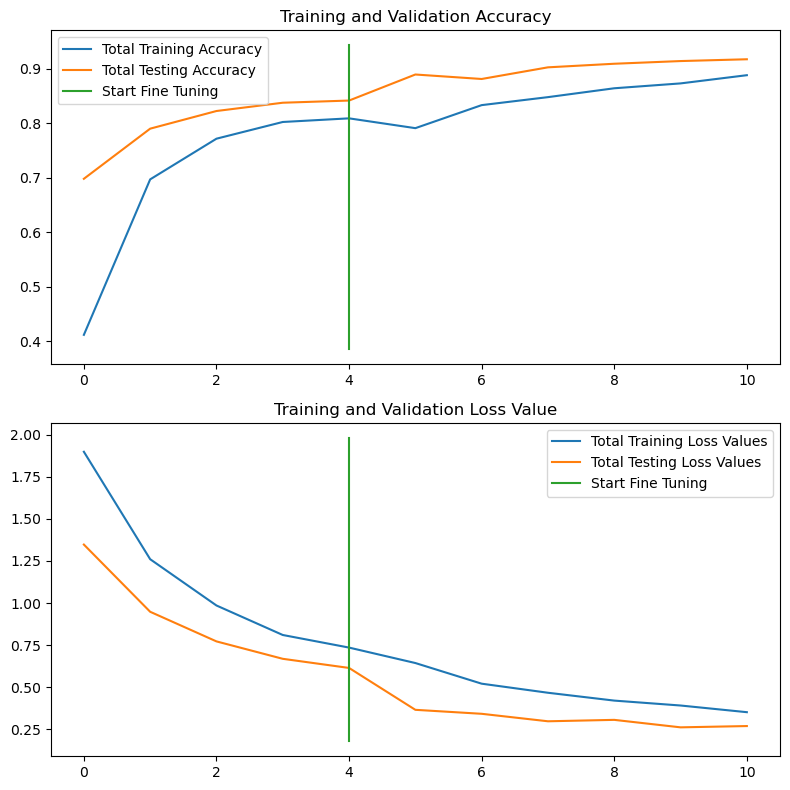

In [ ]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_full,
                  initial_epochs= 5)

## Viewing our experiment data on Tensorboard